In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import DataLoader


data = df = pd.read_csv('training_dataset.csv', index_col="date", parse_dates=True)
data.head()
#source of codes: Greg Hogg - Amazon Stock Forecasting in Pytorch with LSTM Neural Network https://www.youtube.com/watch?v=q_HS4s1L8UI BIG THANKS!

,eth_low,eth_high,eth_open,eth_close,eth_volume,month,eth_qav,eth_num_trades,eth_taker_base_vol,eth_taker_quote_vol,...,stochastic_oscillator,ma_12,ma_26,ema_12,ema_26,obv,mfi,upper_band,middle_band,lower_band
date,,,,,,,,,,,,,,,,,,,,,
2017-09-01,383.18,394.39,386.44,388.46,4198.68434,2017-09-01,1.635228e+06,4124.0,1564.05531,6.096309e+05,...,96.424850,346.524167,338.660000,346.524167,338.660000,1.378006e+06,88.346876,411.653941,341.8790,272.104059
2017-09-02,320.08,394.32,388.58,343.14,8240.32724,2017-09-01,2.904008e+06,8217.0,2460.66776,8.684873e+05,...,97.629707,348.178333,339.773462,348.178333,339.773462,1.369766e+06,80.426793,411.386517,341.6590,271.931483
2017-09-03,320.08,367.28,343.56,341.77,5253.62211,2017-09-01,1.801703e+06,6153.0,2240.91753,7.679383e+05,...,79.514749,350.842500,340.706923,350.842500,340.706923,1.364512e+06,74.419284,408.329187,340.1235,271.917813
2017-09-04,267.94,344.55,339.29,283.77,6737.81061,2017-09-01,2.002446e+06,7403.0,2954.16805,8.770111e+05,...,78.967144,348.178333,339.138077,348.178333,339.138077,1.357774e+06,67.246410,404.443029,335.1070,265.770971
2017-09-05,235.55,321.52,286.81,312.09,8344.41924,2017-09-01,2.397491e+06,8999.0,4312.97282,1.251959e+06,...,55.783836,347.234167,338.443846,347.234167,338.443846,1.366118e+06,66.412993,396.369992,331.2515,266.133008


In [2]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, device):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1) ## output 1
        self.device = device

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(self.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [4]:
def train_one_epoch(model, epoch, train_loader, device, loss_function, optimizer):
    model = model #ha rossz akkor törölni
    epoch = epoch
    train_loader = train_loader
    device = device
    loss_function = loss_function
    optimizer = optimizer
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [5]:
def validate_one_epoch(model, epoch, test_loader, device, loss_function, optimizer):
    model = model  #ha rossz akkor törölni
    epoch = epoch
    test_loader = test_loader
    device = device 
    loss_function = loss_function
    optimizer = optimizer
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [6]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
        
    for i in range(1, n_steps+1):
        df[f'eth_close(t-{i})'] = df['eth_close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

In [7]:
def gridsearch_timeseriessplit(data, columns, lookback, test_size=14, batch_size=16, learning_rate=0.0025, num_epochs=15, tss_split=10, plot_train=False, plot_test=False):
    
    tss = TimeSeriesSplit(n_splits=tss_split, test_size=test_size, gap=0) #jo
    batch_size = batch_size

    root_mean_squared_errors = []
    mean_squared_errors = []
    mean_absolute_errors = []
    mean_absolute_percentage_errors = []
    lookback = lookback
    data = data[columns]
    shifted_df = prepare_dataframe_for_lstm(data, lookback)
    learning_rate = learning_rate
    num_epochs = num_epochs
    
    for train_idx, val_idx in tss.split(shifted_df): 
        
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        shifted_df = prepare_dataframe_for_lstm(data, lookback)
        train_indexek = shifted_df.iloc[train_idx].index
        test_indexek = shifted_df.iloc[val_idx].index
        
        shifted_df_as_np = shifted_df.to_numpy()

        scaler = MinMaxScaler(feature_range=(-1, 1))
        shifted_df_as_np = scaler.fit_transform(shifted_df_as_np) ## érdekes mert testet is megismeri

        X = shifted_df_as_np[:, 1:] ## első oszlop tartalmazza a forecastot, így kiszűrjük
        y = shifted_df_as_np[:, 0]

        X = dc(np.flip(X, axis=1)) ## mirror columns - csak azért, mert LSTM recurring miatt balról-jobbra tanul balról régebbiek jobbról újabbak

        #split_index = test_size

        X_train = X[train_idx]
        X_test = X[val_idx]

        y_train = y[train_idx]
        y_test = y[val_idx]
            
        X_train = X_train.reshape((-1, lookback, 1))
        X_test = X_test.reshape((-1, lookback, 1))

        y_train = y_train.reshape((-1, 1))
        y_test = y_test.reshape((-1, 1))
        
        print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

        X_train = torch.tensor(X_train).float()
        y_train = torch.tensor(y_train).float()
        X_test = torch.tensor(X_test).float()
        y_test = torch.tensor(y_test).float()

        train_dataset = TimeSeriesDataset(X_train, y_train)
        test_dataset = TimeSeriesDataset(X_test, y_test)    

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        for _, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            #print(x_batch.shape, y_batch.shape)
            break   
            
        model = LSTM(1, 4, 1, device) #1 feature, 4 hidden size, 1 num stacked layer (ha multioutput akkor pl itt is változtatni kell)
        ##EZT LEHET MAJD A JÖVŐBEN GRIDSEARCHELNI
        model.to(device)            
            
        loss_function = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            train_one_epoch(model, epoch, train_loader, device, loss_function, optimizer)
            validate_one_epoch(model, epoch, test_loader, device, loss_function, optimizer)
            

        ## TRAIN PREDICTIONS ## if you want to plot
        
        with torch.no_grad():
            predicted = model(X_train.to(device)).to('cpu').numpy() 
        
        if plot_train:
            fig, ax = plt.subplots(figsize=(10, 5))
            font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
            ax.plot(train_indexek, y_train, label="ETH valós értékei")
            ax.plot(train_indexek, predicted, label="ETH prediktált értékei")
            ax.legend()
            ax.yaxis.set_major_formatter("${x:,.0f}")
            ax.set_ylabel("ETH napi árfolyama ($)", **font)
            ax.set_xlabel("dátum", **font)
            plt.tight_layout()
            ax.set_title("LSTM", **font)
            plt.savefig("charts/forecast/lstm_train_example.png")
            plt.show()
        
        train_predictions = predicted.flatten()
        dummies = np.zeros((X_train.shape[0], lookback+1))
        dummies[:, 0] = train_predictions
        dummies = scaler.inverse_transform(dummies)

        train_predictions = dc(dummies[:, 0])
        dummies = np.zeros((X_train.shape[0], lookback+1))
        dummies[:, 0] = y_train.flatten()
        dummies = scaler.inverse_transform(dummies)

        new_y_train = dc(dummies[:, 0])
        
        ## TEST PREDICTIONS
        
        test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

        dummies = np.zeros((X_test.shape[0], lookback+1))
        dummies[:, 0] = test_predictions
        dummies = scaler.inverse_transform(dummies)

        test_predictions = dc(dummies[:, 0])
        
        dummies = np.zeros((X_test.shape[0], lookback+1))
        dummies[:, 0] = y_test.flatten()
        dummies = scaler.inverse_transform(dummies)

        new_y_test = dc(dummies[:, 0])
        
        if plot_test:
            fig, ax = plt.subplots(figsize=(10, 5))
            font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
            ax.plot(test_indexek, new_y_test, label="ETH valós értékei")
            ax.plot(test_indexek, test_predictions, label="ETH prediktált értékei")
            ax.legend()
            ax.yaxis.set_major_formatter("${x:,.0f}")
            ax.set_ylabel("ETH napi árfolyama ($)", **font)
            ax.set_xlabel("dátum", **font)
            plt.tight_layout()
            ax.set_title("LSTM", **font)
            plt.savefig("charts/forecast/lstm_test_example.png")
            plt.show()
        
        evaluation_df = pd.DataFrame()
        evaluation_df["true_values"] = new_y_test
        evaluation_df["predicted_values"] = test_predictions
        print(evaluation_df)
        
        del device
        
        try:
            rmse = mean_squared_error(new_y_test, test_predictions, squared=False)
            root_mean_squared_errors.append(rmse)
            mse = mean_squared_error(new_y_test, test_predictions, squared=True)
            mean_squared_errors.append(mse)        
            mae = mean_absolute_error(new_y_test, test_predictions)
            mean_absolute_errors.append(mae)
            mape = mean_absolute_percentage_error(new_y_test, test_predictions)
            mean_absolute_percentage_errors.append(mape)
        except:
            rmse = np.nan
            mse = np.nan
            mae = np.nan
            mape = np.nan


    print("Tesztelve 10 különböző tanulási/tesztelési adatszetten")
    print(f"RMSE: {round(np.mean(root_mean_squared_errors), 4)}")
    print(f"MSE: {round(np.mean(mean_squared_errors), 4)}")
    print(f"MAE: {round(np.mean(mean_absolute_errors), 4)}")
    print(f"MAPE: {str(round(np.mean(mean_absolute_percentage_errors)*100, 4))}%")

    return model, evaluation_df, round(np.mean(root_mean_squared_errors), 4), round(np.mean(mean_squared_errors), 4),round(np.mean(mean_absolute_errors), 4),round(np.mean(mean_absolute_percentage_errors)*100, 4)
        

## Gridsearch for best combination

## DAY 1

In [8]:

model, evaluation_df, rmse, mse, mae, mape = gridsearch_timeseriessplit(data, ["eth_close"], lookback = 3, test_size=1, batch_size=16, learning_rate=0.002, num_epochs=15, tss_split=10)

(2001, 3, 1) (1, 3, 1) (2001, 1) (1, 1)
Epoch: 1
Batch 100, Loss: 0.506

Val Loss: 0.011
***************************************************

Epoch: 2
Batch 100, Loss: 0.128

Val Loss: 0.022
***************************************************

Epoch: 3
Batch 100, Loss: 0.035

Val Loss: 0.000
***************************************************

Epoch: 4
Batch 100, Loss: 0.008

Val Loss: 0.000
***************************************************

Epoch: 5
Batch 100, Loss: 0.005

Val Loss: 0.000
***************************************************

Epoch: 6
Batch 100, Loss: 0.004

Val Loss: 0.000
***************************************************

Epoch: 7
Batch 100, Loss: 0.004

Val Loss: 0.000
***************************************************

Epoch: 8
Batch 100, Loss: 0.004

Val Loss: 0.000
***************************************************

Epoch: 9
Batch 100, Loss: 0.003

Val Loss: 0.000
***************************************************

Epoch: 10
Batch 100, Loss: 0.003

Val Loss

Batch 100, Loss: 0.231

Val Loss: 0.013
***************************************************

Epoch: 2
Batch 100, Loss: 0.030

Val Loss: 0.010
***************************************************

Epoch: 3
Batch 100, Loss: 0.008

Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.005

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.004

Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.003

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.002

Val Loss: 0.001
***************************************************

Epoch: 8
Batch 100, Loss: 0.002

Val Loss: 0.001
***************************************************

Epoch: 9
Batch 100, Loss: 0.002

Val Loss: 0.001
***************************************************

Epoch: 10
Batch 100, Loss: 0.002

Val Loss: 0.002
*****************************************

## DAY 3

In [9]:

model, evaluation_df, rmse, mse, mae, mape = gridsearch_timeseriessplit(data, ["eth_close"], lookback = 5, test_size=3, batch_size=16, learning_rate=0.002, num_epochs=15, tss_split=10)

(1979, 5, 1) (3, 5, 1) (1979, 1) (3, 1)
Epoch: 1
Batch 100, Loss: 0.145

Val Loss: 0.000
***************************************************

Epoch: 2
Batch 100, Loss: 0.009

Val Loss: 0.000
***************************************************

Epoch: 3
Batch 100, Loss: 0.005

Val Loss: 0.000
***************************************************

Epoch: 4
Batch 100, Loss: 0.004

Val Loss: 0.000
***************************************************

Epoch: 5
Batch 100, Loss: 0.003

Val Loss: 0.000
***************************************************

Epoch: 6
Batch 100, Loss: 0.003

Val Loss: 0.000
***************************************************

Epoch: 7
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 8
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 9
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 10
Batch 100, Loss: 0.002

Val Loss

Batch 100, Loss: 0.003

Val Loss: 0.000
***************************************************

Epoch: 15
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

   true_values  predicted_values
0  1691.619987       1642.911758
1  1679.750034       1674.022797
2  1703.270022       1688.504244
(1994, 5, 1) (3, 5, 1) (1994, 1) (3, 1)
Epoch: 1
Batch 100, Loss: 0.387

Val Loss: 0.070
***************************************************

Epoch: 2
Batch 100, Loss: 0.184

Val Loss: 0.047
***************************************************

Epoch: 3
Batch 100, Loss: 0.081

Val Loss: 0.005
***************************************************

Epoch: 4
Batch 100, Loss: 0.011

Val Loss: 0.000
***************************************************

Epoch: 5
Batch 100, Loss: 0.006

Val Loss: 0.000
***************************************************

Epoch: 6
Batch 100, Loss: 0.004

Val Loss: 0.000
***************************************************

Epoch: 7
Batch 100, 

Batch 100, Loss: 0.003

Val Loss: 0.000
***************************************************

Epoch: 12
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 13
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 14
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 15
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

   true_values  predicted_values
0  1564.580034       1562.975842
1  1565.839988       1548.495732
2  1561.960022       1542.171745
Tesztelve 10 különböző tanulási/tesztelési adatszetten
RMSE: 51.6113
MSE: 3625.9736
MAE: 45.9214
MAPE: 2.8667%


## DAY 7

(1935, 9, 1) (7, 9, 1) (1935, 1) (7, 1)
Epoch: 1
Batch 100, Loss: 0.158

Val Loss: 0.000
***************************************************

Epoch: 2
Batch 100, Loss: 0.006

Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Loss: 0.004

Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.003

Val Loss: 0.002
***************************************************

Epoch: 5
Batch 100, Loss: 0.003

Val Loss: 0.000
***************************************************

Epoch: 6
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 7
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 8
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 9
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 10
Batch 100, Loss: 0.002

Val Loss

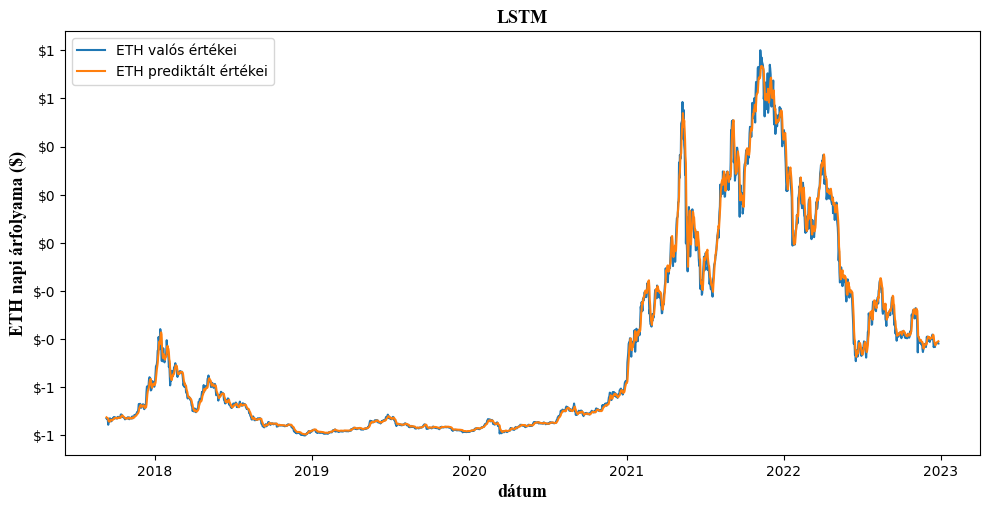

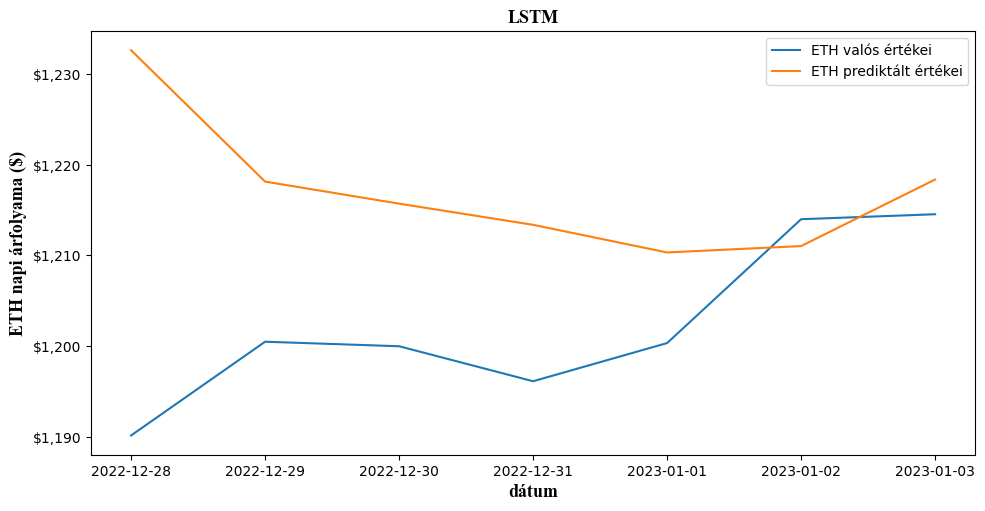

   true_values  predicted_values
0  1190.149942       1232.635977
1  1200.490041       1218.150658
2  1199.989945       1215.718323
3  1196.129972       1213.383135
4  1200.339956       1210.334691
5  1213.999948       1211.038936
6  1214.550025       1218.376772
(1942, 9, 1) (7, 9, 1) (1942, 1) (7, 1)
Epoch: 1
Batch 100, Loss: 0.384

Val Loss: 0.013
***************************************************

Epoch: 2
Batch 100, Loss: 0.041

Val Loss: 0.000
***************************************************

Epoch: 3
Batch 100, Loss: 0.012

Val Loss: 0.004
***************************************************

Epoch: 4
Batch 100, Loss: 0.008

Val Loss: 0.004
***************************************************

Epoch: 5
Batch 100, Loss: 0.005

Val Loss: 0.002
***************************************************

Epoch: 6
Batch 100, Loss: 0.004

Val Loss: 0.002
***************************************************

Epoch: 7
Batch 100, Loss: 0.003

Val Loss: 0.001
***********************************

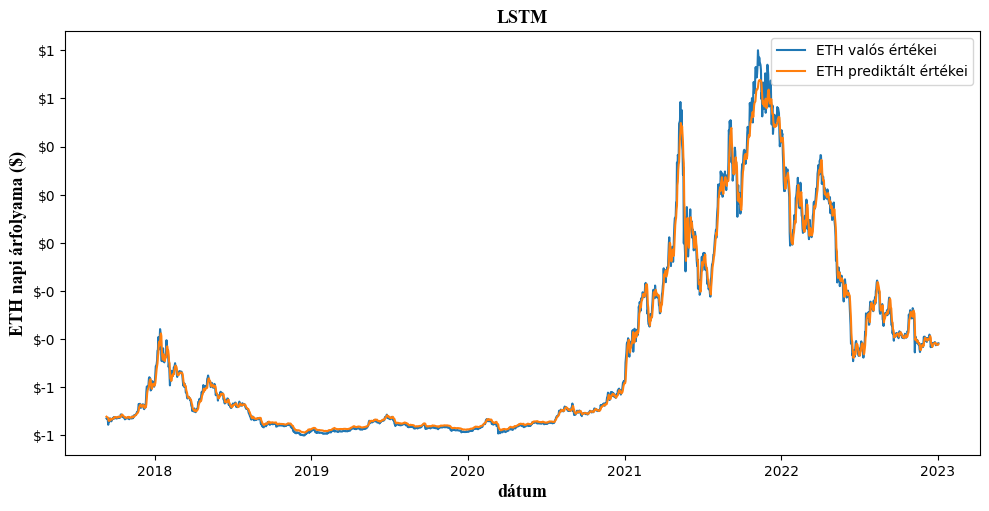

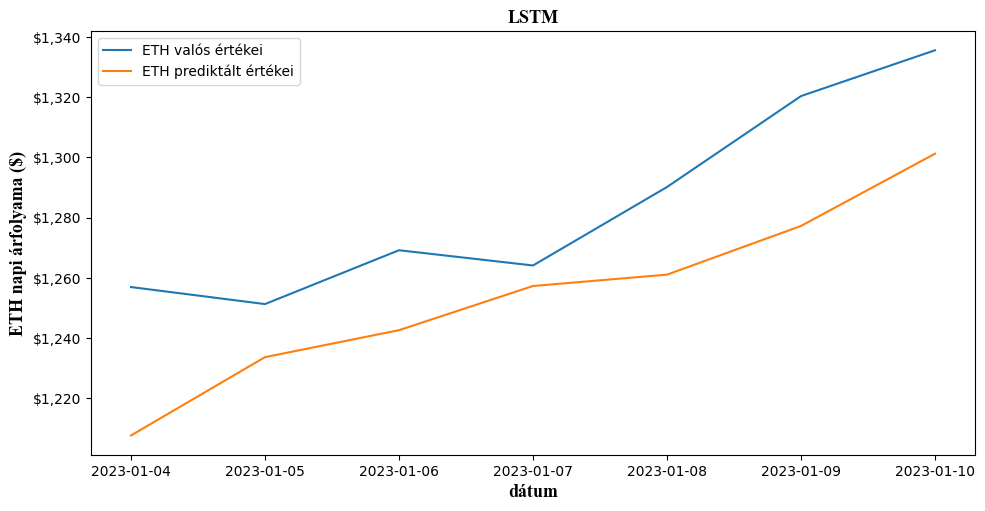

   true_values  predicted_values
0  1256.900055       1207.561778
1  1251.240047       1233.593650
2  1269.140012       1242.562005
3  1264.070066       1257.251052
4  1290.160014       1261.022466
5  1320.389973       1277.213771
6  1335.620015       1301.240050
(1949, 9, 1) (7, 9, 1) (1949, 1) (7, 1)
Epoch: 1
Batch 100, Loss: 0.299

Val Loss: 0.004
***************************************************

Epoch: 2
Batch 100, Loss: 0.131

Val Loss: 0.015
***************************************************

Epoch: 3
Batch 100, Loss: 0.008

Val Loss: 0.004
***************************************************

Epoch: 4
Batch 100, Loss: 0.004

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.003

Val Loss: 0.000
***************************************************

Epoch: 6
Batch 100, Loss: 0.003

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.003

Val Loss: 0.001
***********************************

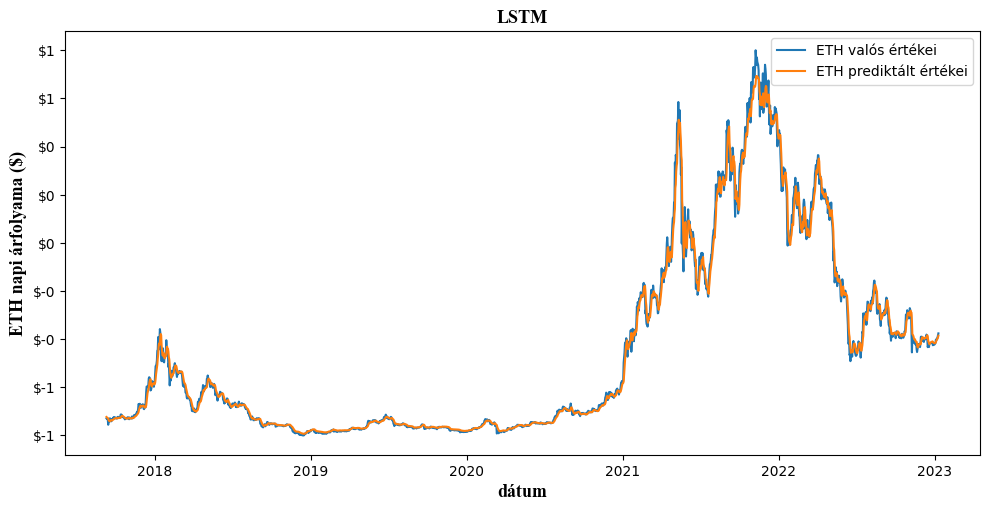

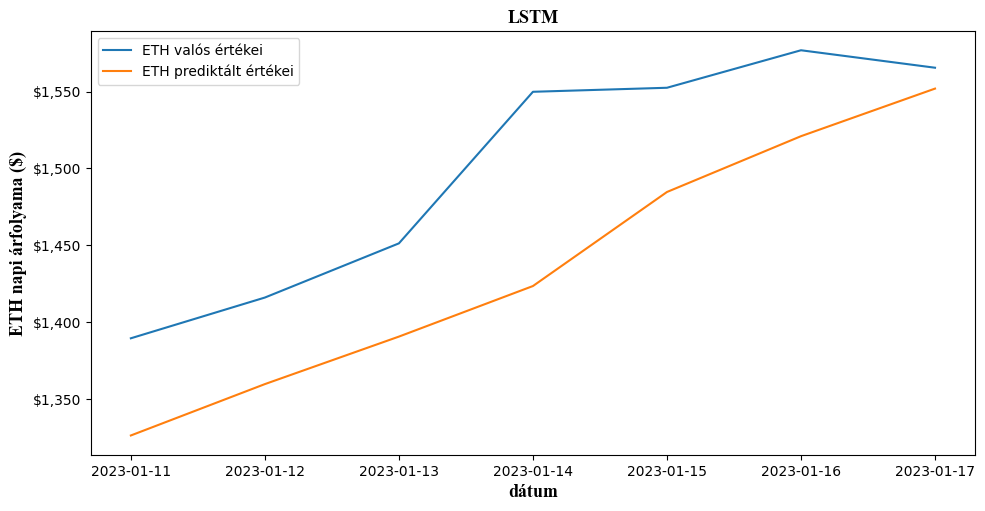

   true_values  predicted_values
0  1389.390024       1326.111719
1  1415.920020       1359.555693
2  1451.200003       1390.490601
3  1549.899999       1423.413291
4  1552.520011       1484.650032
5  1576.940017       1520.987368
6  1565.570018       1551.972046
(1956, 9, 1) (7, 9, 1) (1956, 1) (7, 1)
Epoch: 1
Batch 100, Loss: 0.538

Val Loss: 0.055
***************************************************

Epoch: 2
Batch 100, Loss: 0.042

Val Loss: 0.004
***************************************************

Epoch: 3
Batch 100, Loss: 0.013

Val Loss: 0.003
***************************************************

Epoch: 4
Batch 100, Loss: 0.007

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.005

Val Loss: 0.002
***************************************************

Epoch: 6
Batch 100, Loss: 0.004

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.003

Val Loss: 0.001
***********************************

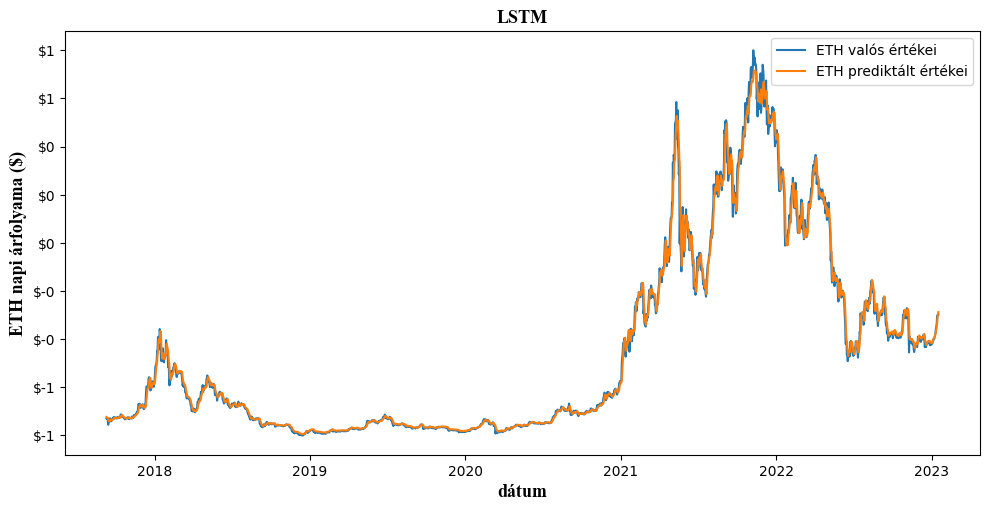

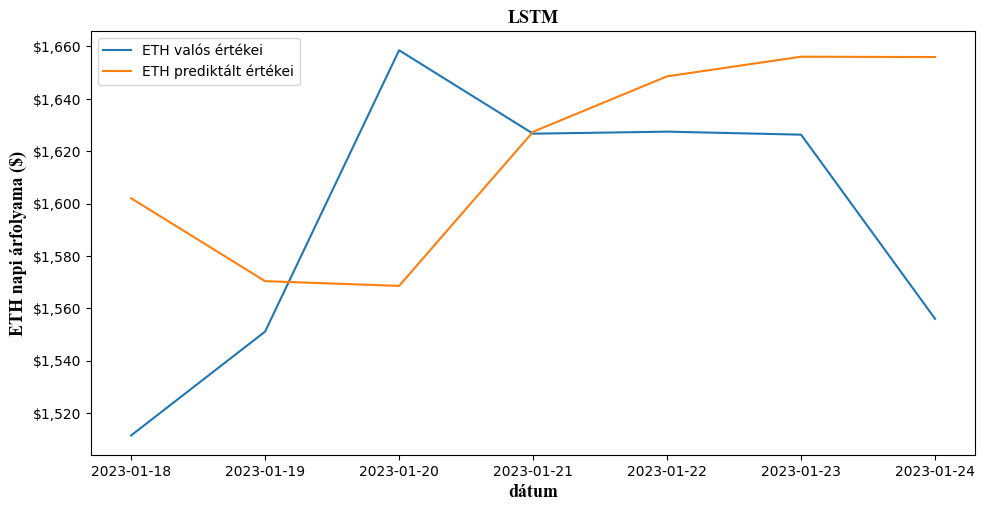

   true_values  predicted_values
0  1511.430005       1602.009007
1  1551.089979       1570.355986
2  1658.519969       1568.539055
3  1626.659983       1627.399637
4  1627.439975       1648.565360
5  1626.289980       1656.061376
6  1555.969996       1655.930228
(1963, 9, 1) (7, 9, 1) (1963, 1) (7, 1)
Epoch: 1
Batch 100, Loss: 0.152

Val Loss: 0.000
***************************************************

Epoch: 2
Batch 100, Loss: 0.019

Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Loss: 0.005

Val Loss: 0.000
***************************************************

Epoch: 4
Batch 100, Loss: 0.003

Val Loss: 0.000
***************************************************

Epoch: 5
Batch 100, Loss: 0.003

Val Loss: 0.000
***************************************************

Epoch: 6
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 7
Batch 100, Loss: 0.002

Val Loss: 0.000
***********************************

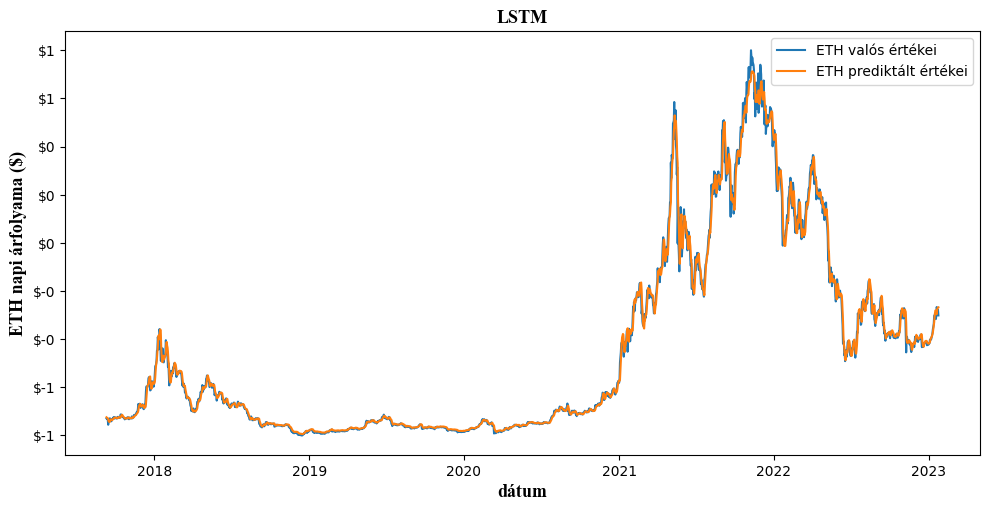

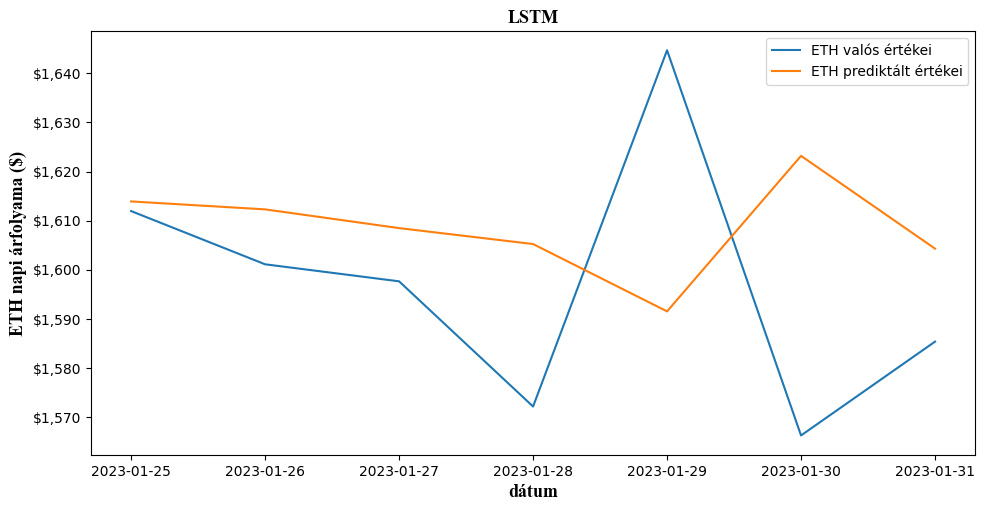

   true_values  predicted_values
0  1611.940033       1613.904795
1  1601.089982       1612.287932
2  1597.620004       1608.466817
3  1572.099985       1605.220277
4  1644.720029       1591.492001
5  1566.199995       1623.195567
6  1585.329996       1604.284851
(1970, 9, 1) (7, 9, 1) (1970, 1) (7, 1)
Epoch: 1
Batch 100, Loss: 0.165

Val Loss: 0.012
***************************************************

Epoch: 2
Batch 100, Loss: 0.028

Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Loss: 0.012

Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.006

Val Loss: 0.000
***************************************************

Epoch: 5
Batch 100, Loss: 0.004

Val Loss: 0.000
***************************************************

Epoch: 6
Batch 100, Loss: 0.003

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.003

Val Loss: 0.000
***********************************

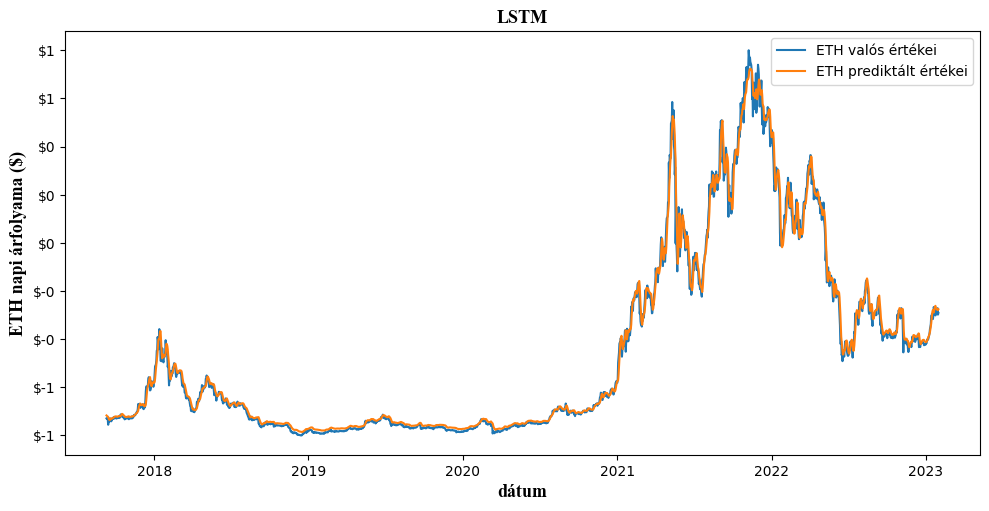

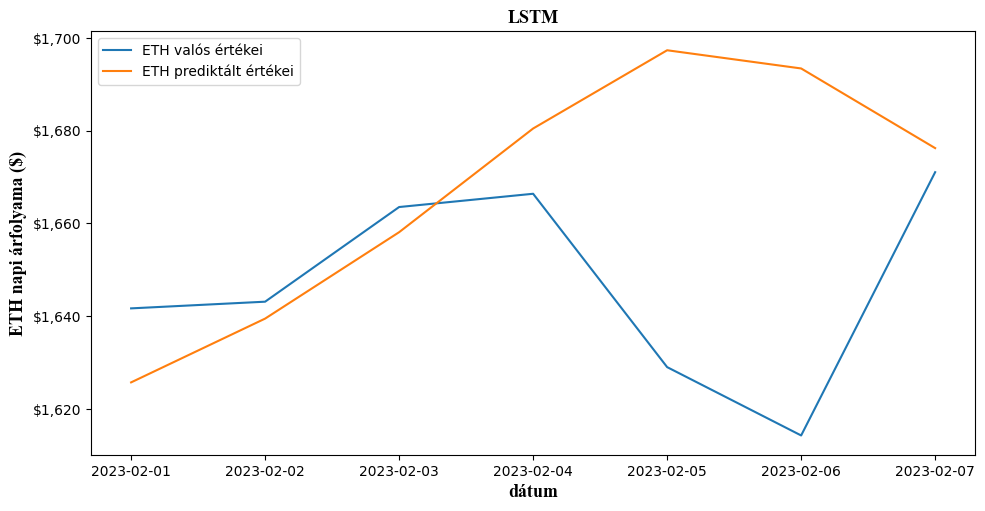

   true_values  predicted_values
0  1641.680033       1625.729695
1  1643.119990       1639.473881
2  1663.520012       1658.096817
3  1666.380005       1680.444072
4  1629.020021       1697.306958
5  1614.290004       1693.384895
6  1671.029966       1676.218460
(1977, 9, 1) (7, 9, 1) (1977, 1) (7, 1)
Epoch: 1
Batch 100, Loss: 0.303

Val Loss: 0.017
***************************************************

Epoch: 2
Batch 100, Loss: 0.031

Val Loss: 0.003
***************************************************

Epoch: 3
Batch 100, Loss: 0.018

Val Loss: 0.003
***************************************************

Epoch: 4
Batch 100, Loss: 0.013

Val Loss: 0.003
***************************************************

Epoch: 5
Batch 100, Loss: 0.009

Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.007

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.007

Val Loss: 0.000
***********************************

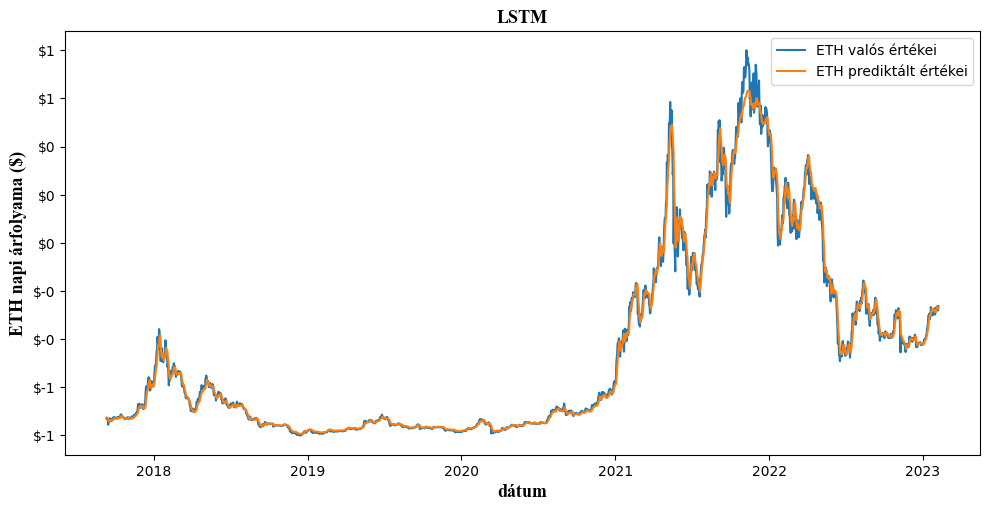

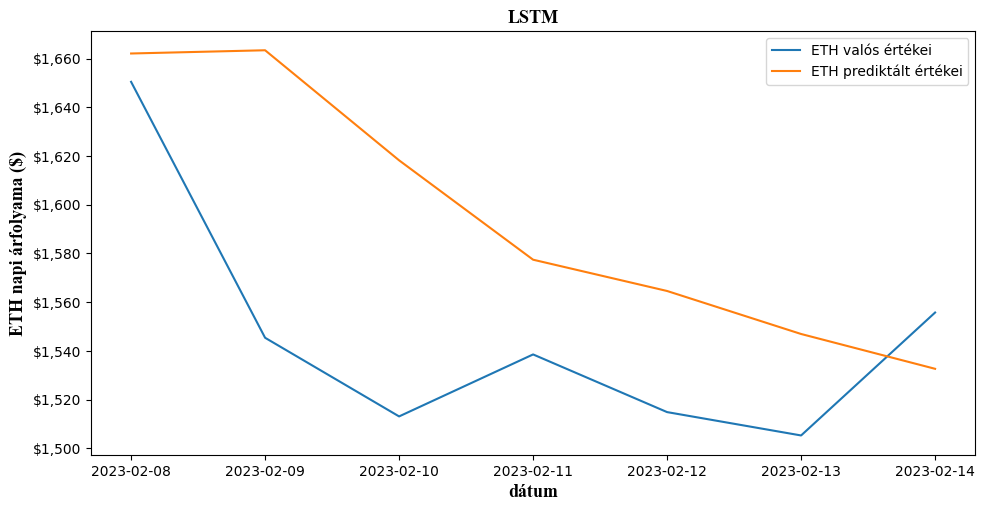

   true_values  predicted_values
0  1650.430019       1662.066890
1  1545.350000       1663.394565
2  1513.060033       1618.201226
3  1538.510008       1577.404281
4  1514.830009       1564.557930
5  1505.239983       1546.902240
6  1555.710022       1532.608822
(1984, 9, 1) (7, 9, 1) (1984, 1) (7, 1)
Epoch: 1
Batch 100, Loss: 0.228

Val Loss: 0.022
***************************************************

Epoch: 2
Batch 100, Loss: 0.018

Val Loss: 0.002
***************************************************

Epoch: 3
Batch 100, Loss: 0.006

Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.003

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.003

Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.002

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.002

Val Loss: 0.001
***********************************

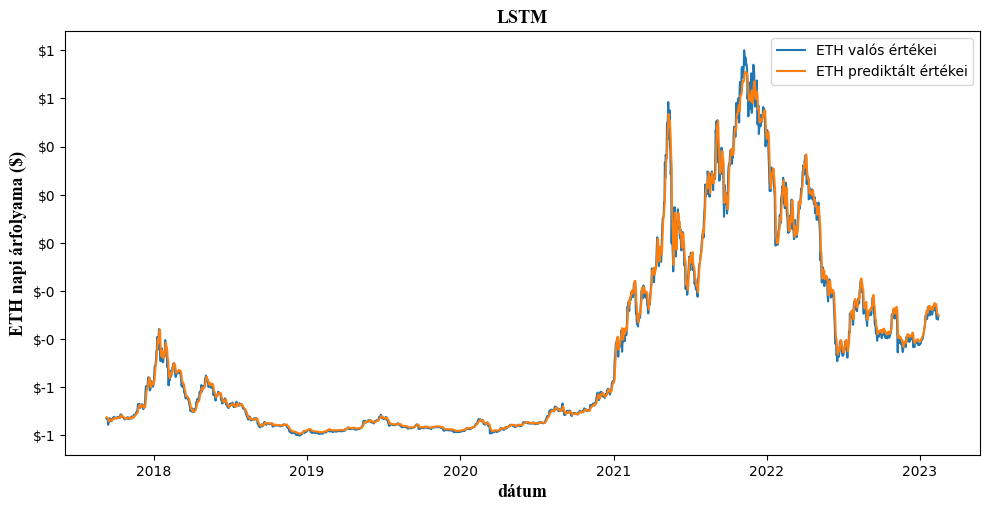

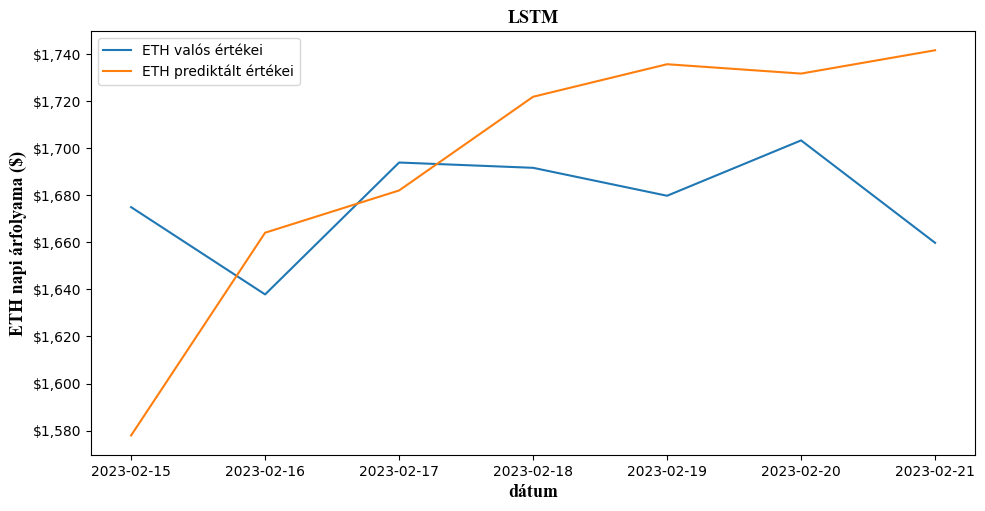

   true_values  predicted_values
0  1674.919999       1577.930142
1  1637.839981       1664.052701
2  1693.869996       1682.003422
3  1691.619987       1721.804892
4  1679.750034       1735.624050
5  1703.270022       1731.651302
6  1659.760001       1741.556070
(1991, 9, 1) (7, 9, 1) (1991, 1) (7, 1)
Epoch: 1
Batch 100, Loss: 0.259

Val Loss: 0.027
***************************************************

Epoch: 2
Batch 100, Loss: 0.043

Val Loss: 0.007
***************************************************

Epoch: 3
Batch 100, Loss: 0.010

Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.005

Val Loss: 0.002
***************************************************

Epoch: 5
Batch 100, Loss: 0.003

Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.003

Val Loss: 0.000
***************************************************

Epoch: 7
Batch 100, Loss: 0.002

Val Loss: 0.000
***********************************

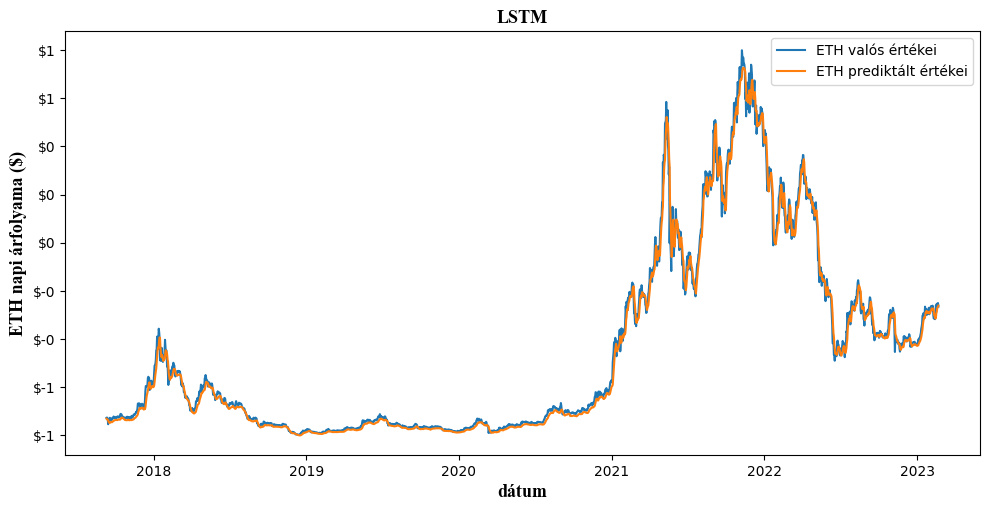

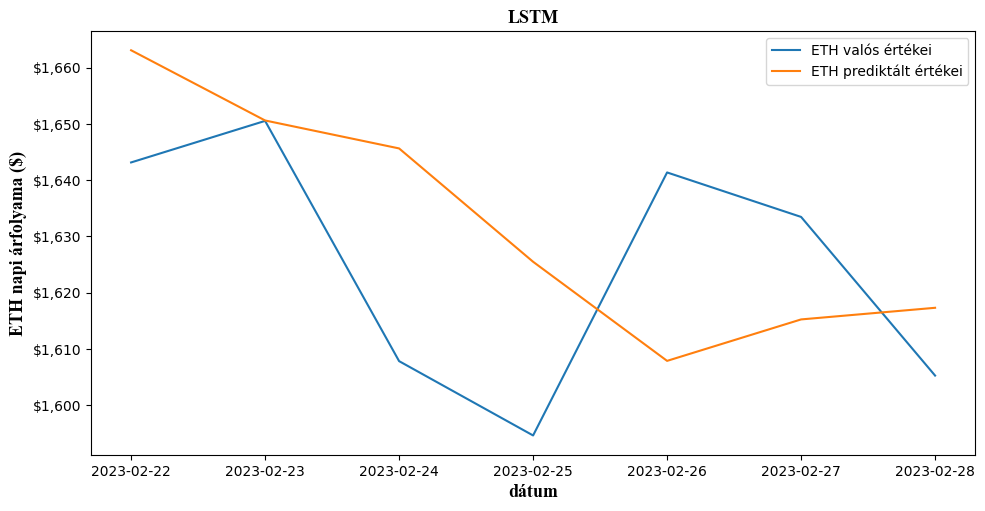

   true_values  predicted_values
0  1643.139983       1663.092424
1  1650.529982       1650.604391
2  1607.800023       1645.632859
3  1594.580008       1625.474297
4  1641.360011       1607.846555
5  1633.449994       1615.219095
6  1605.229992       1617.287200
(1998, 9, 1) (7, 9, 1) (1998, 1) (7, 1)
Epoch: 1
Batch 100, Loss: 0.111

Val Loss: 0.003
***************************************************

Epoch: 2
Batch 100, Loss: 0.009

Val Loss: 0.001
***************************************************

Epoch: 3
Batch 100, Loss: 0.005

Val Loss: 0.000
***************************************************

Epoch: 4
Batch 100, Loss: 0.004

Val Loss: 0.000
***************************************************

Epoch: 5
Batch 100, Loss: 0.003

Val Loss: 0.000
***************************************************

Epoch: 6
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 7
Batch 100, Loss: 0.002

Val Loss: 0.001
***********************************

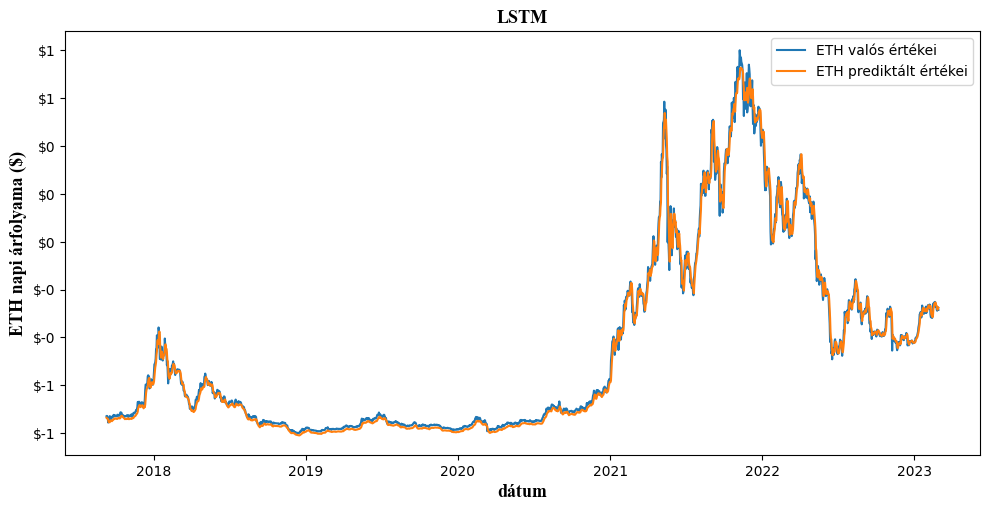

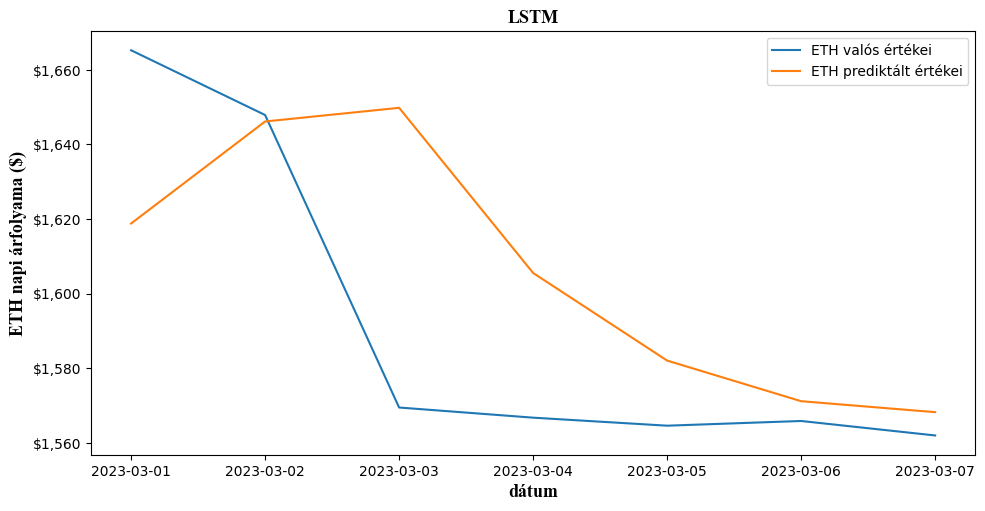

   true_values  predicted_values
0  1665.220013       1618.775308
1  1647.859989       1646.127323
2  1569.449984       1649.787511
3  1566.730010       1605.518758
4  1564.580034       1582.031856
5  1565.839988       1571.142735
6  1561.960022       1568.206433
Tesztelve 10 különböző tanulási/tesztelési adatszetten
RMSE: 44.6416
MSE: 2288.6986
MAE: 36.5572
MAPE: 2.3935%


In [10]:

model, evaluation_df, rmse, mse, mae, mape = gridsearch_timeseriessplit(data, ["eth_close"], lookback = 9, test_size=7, batch_size=16, learning_rate=0.002, num_epochs=15, tss_split=10, plot_train=True, plot_test=True)

## DAY 14

(1846, 28, 1) (14, 28, 1) (1846, 1) (14, 1)
Epoch: 1
Batch 100, Loss: 0.885

Val Loss: 0.071
***************************************************

Epoch: 2
Batch 100, Loss: 0.138

Val Loss: 0.029
***************************************************

Epoch: 3
Batch 100, Loss: 0.025

Val Loss: 0.003
***************************************************

Epoch: 4
Batch 100, Loss: 0.012

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.007

Val Loss: 0.002
***************************************************

Epoch: 6
Batch 100, Loss: 0.005

Val Loss: 0.001
***************************************************

Epoch: 7
Batch 100, Loss: 0.004

Val Loss: 0.001
***************************************************

Epoch: 8
Batch 100, Loss: 0.004

Val Loss: 0.001
***************************************************

Epoch: 9
Batch 100, Loss: 0.003

Val Loss: 0.001
***************************************************

Epoch: 10
Batch 100, Loss: 0.003

Val 

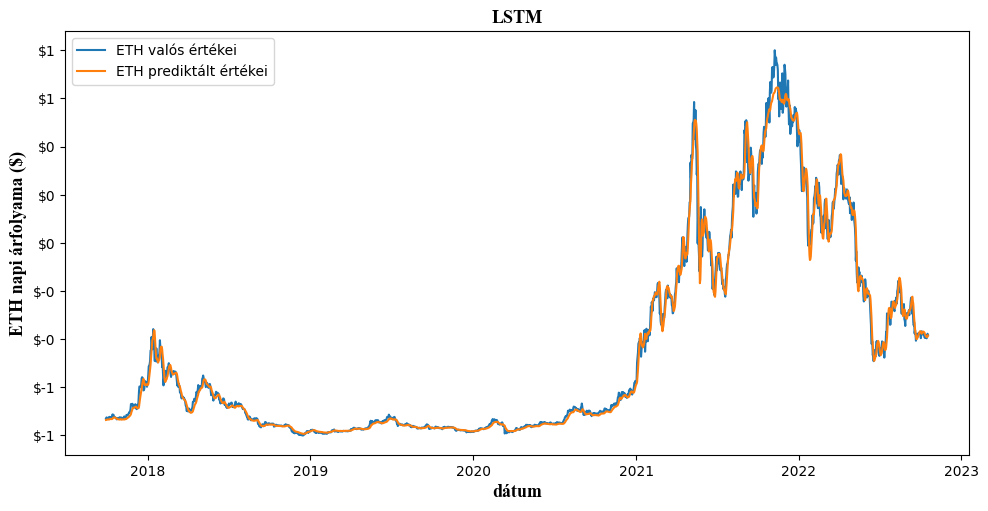

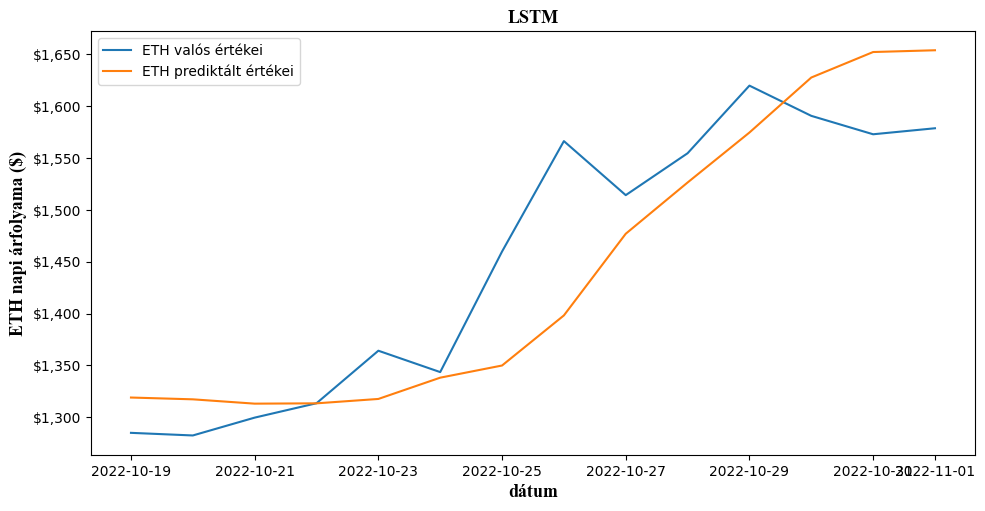

    true_values  predicted_values
0   1285.089998       1319.104113
1   1282.570019       1317.376163
2   1299.749970       1313.212218
3   1313.610028       1313.515345
4   1364.200023       1317.739690
5   1343.610002       1338.231086
6   1459.739997       1349.950814
7   1566.100033       1398.207943
8   1514.050017       1476.866869
9   1554.410012       1526.225420
10  1619.550020       1574.365692
11  1590.439998       1627.349515
12  1572.689977       1651.916016
13  1578.480007       1653.613976
(1860, 28, 1) (14, 28, 1) (1860, 1) (14, 1)
Epoch: 1
Batch 100, Loss: 0.224

Val Loss: 0.004
***************************************************

Epoch: 2
Batch 100, Loss: 0.043

Val Loss: 0.004
***************************************************

Epoch: 3
Batch 100, Loss: 0.010

Val Loss: 0.003
***************************************************

Epoch: 4
Batch 100, Loss: 0.005

Val Loss: 0.003
***************************************************

Epoch: 5
Batch 100, Loss: 0.003

Val L

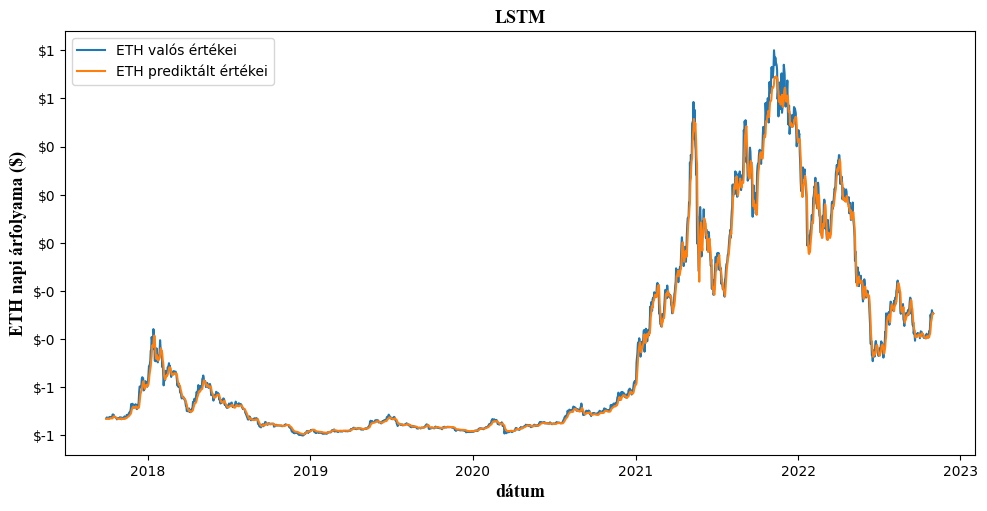

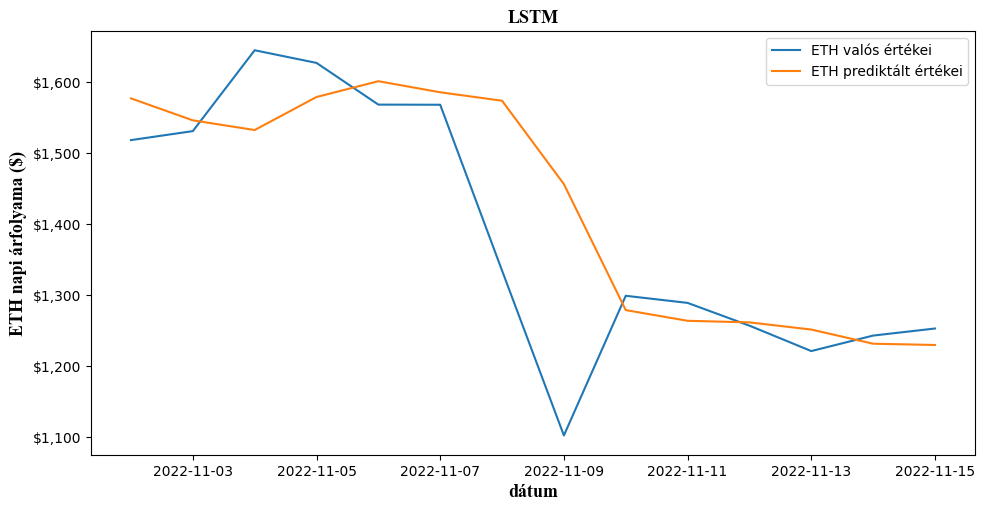

    true_values  predicted_values
0   1518.339972       1577.060676
1   1531.009980       1546.162797
2   1644.780007       1532.520615
3   1626.980005       1579.007487
4   1568.289993       1601.230564
5   1568.099993       1585.651848
6   1334.769979       1573.769294
7   1102.730048       1456.404124
8   1299.280004       1279.144180
9   1289.279989       1264.076965
10  1257.250066       1261.869616
11  1221.489980       1251.770272
12  1243.280048       1231.839372
13  1253.230011       1230.037225
(1874, 28, 1) (14, 28, 1) (1874, 1) (14, 1)
Epoch: 1
Batch 100, Loss: 0.173

Val Loss: 0.004
***************************************************

Epoch: 2
Batch 100, Loss: 0.014

Val Loss: 0.003
***************************************************

Epoch: 3
Batch 100, Loss: 0.005

Val Loss: 0.002
***************************************************

Epoch: 4
Batch 100, Loss: 0.003

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.003

Val L

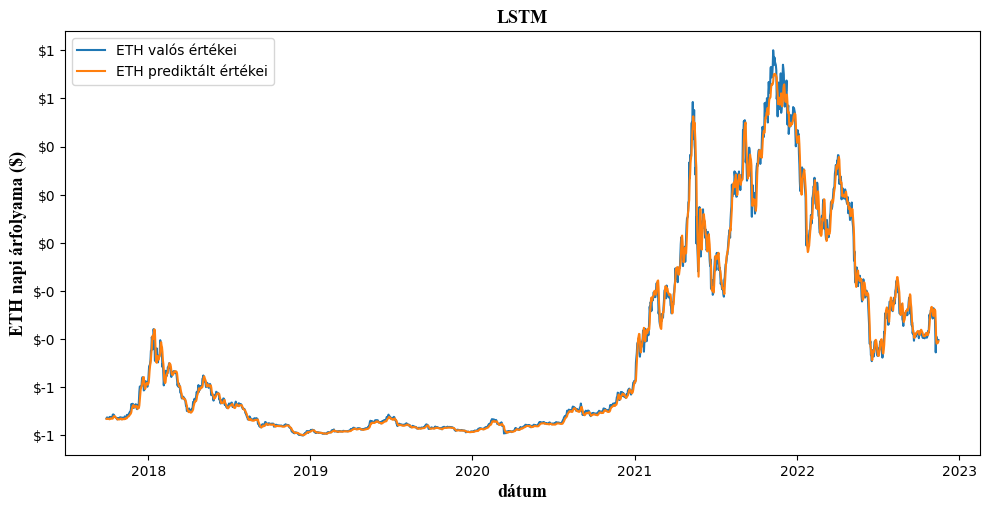

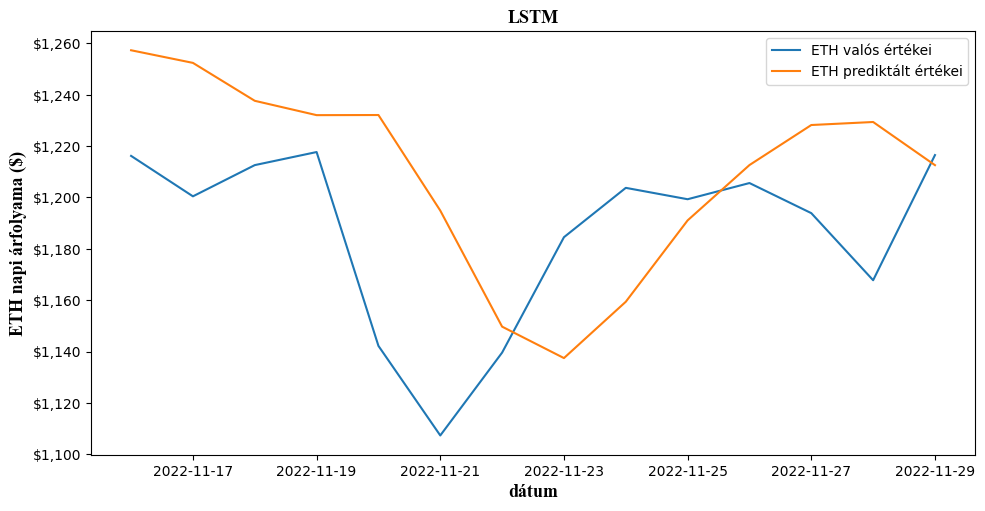

    true_values  predicted_values
0   1216.169986       1257.289910
1   1200.430063       1252.373851
2   1212.580053       1237.614831
3   1217.669992       1232.031413
4   1142.210018       1232.078297
5   1107.340024       1194.878043
6   1139.600002       1149.693855
7   1184.520063       1137.462769
8   1203.729963       1159.390391
9   1199.300061       1191.063405
10  1205.599972       1212.600891
11  1193.879963       1228.187209
12  1167.769952       1229.363250
13  1216.490008       1212.562032
(1888, 28, 1) (14, 28, 1) (1888, 1) (14, 1)
Epoch: 1
Batch 100, Loss: 0.114

Val Loss: 0.001
***************************************************

Epoch: 2
Batch 100, Loss: 0.013

Val Loss: 0.000
***************************************************

Epoch: 3
Batch 100, Loss: 0.004

Val Loss: 0.000
***************************************************

Epoch: 4
Batch 100, Loss: 0.003

Val Loss: 0.000
***************************************************

Epoch: 5
Batch 100, Loss: 0.002

Val L

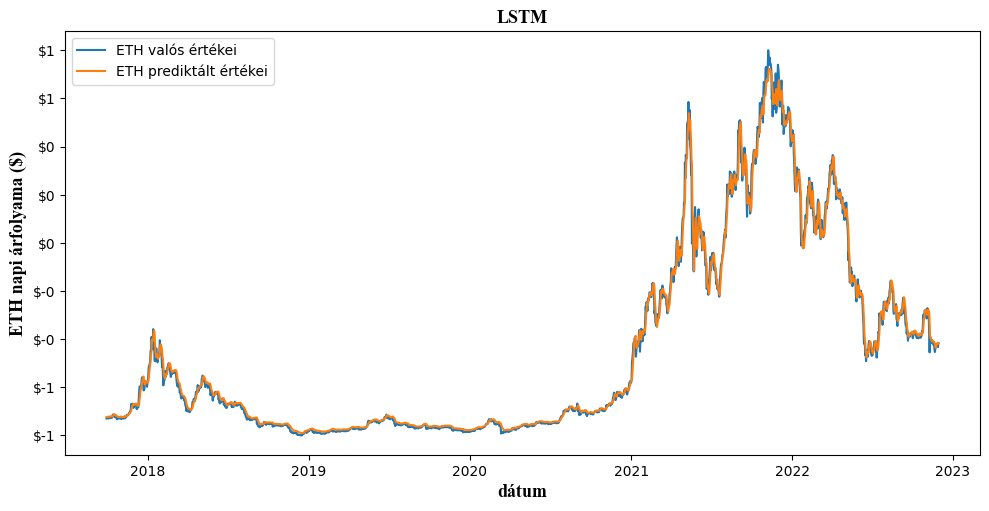

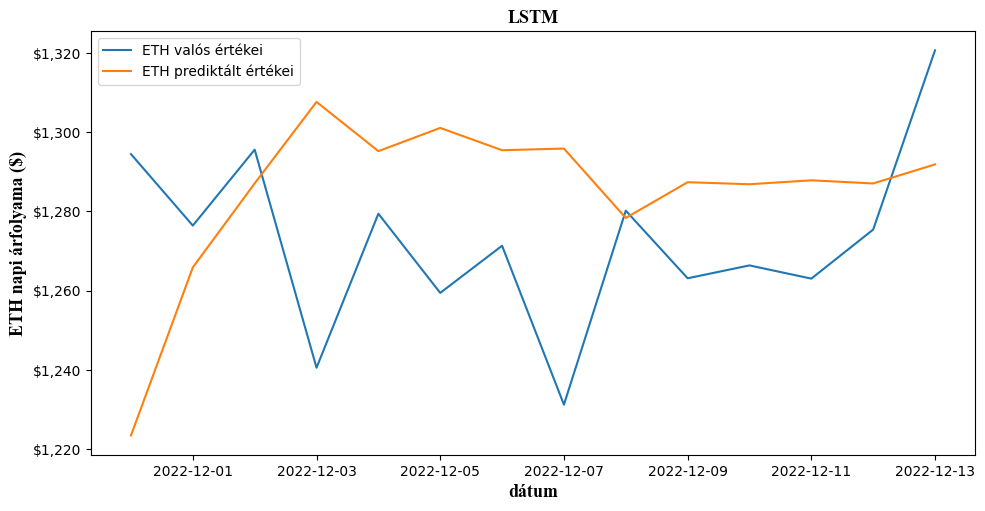

    true_values  predicted_values
0   1294.460035       1223.401242
1   1276.409985       1265.849545
2   1295.589967       1287.066023
3   1240.509951       1307.643655
4   1279.409997       1295.211305
5   1259.409967       1301.076378
6   1271.319976       1295.447133
7   1231.180040       1295.861768
8   1280.179992       1278.336593
9   1263.100004       1287.365630
10  1266.349993       1286.850470
11  1263.010037       1287.844607
12  1275.400008       1287.051733
13  1320.690002       1291.859875
(1902, 28, 1) (14, 28, 1) (1902, 1) (14, 1)
Epoch: 1
Batch 100, Loss: 0.556

Val Loss: 0.010
***************************************************

Epoch: 2
Batch 100, Loss: 0.027

Val Loss: 0.006
***************************************************

Epoch: 3
Batch 100, Loss: 0.011

Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.008

Val Loss: 0.002
***************************************************

Epoch: 5
Batch 100, Loss: 0.006

Val L

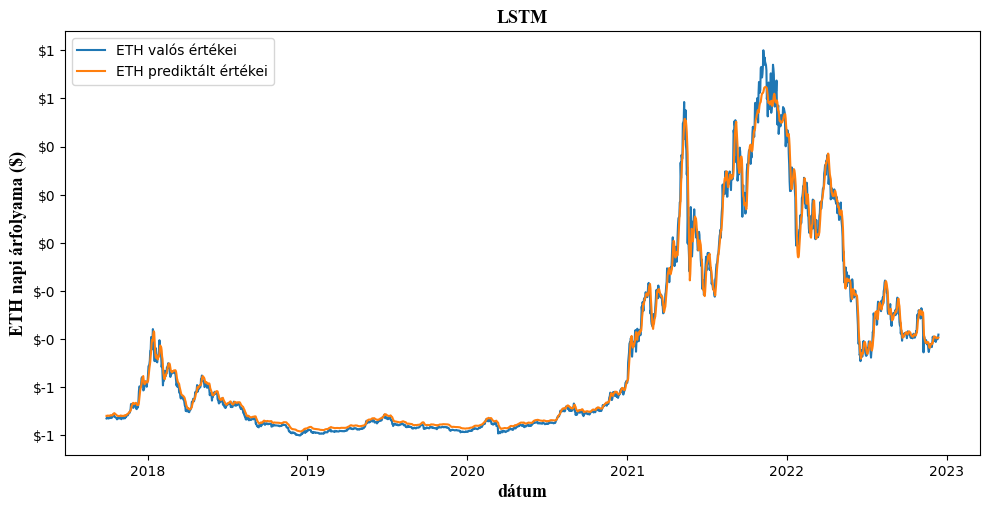

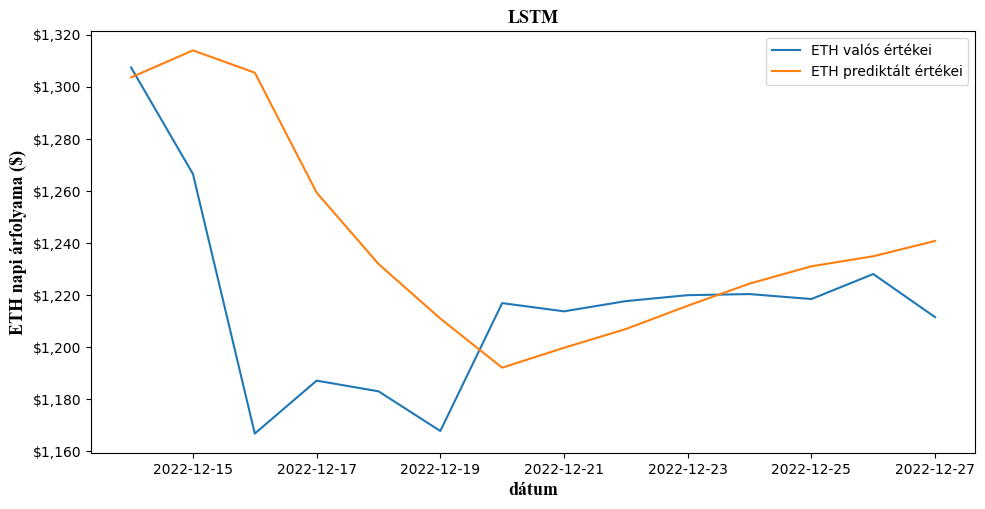

    true_values  predicted_values
0   1307.439998       1303.652674
1   1266.539992       1314.018961
2   1166.830020       1305.445810
3   1187.160067       1259.380542
4   1183.060042       1231.991710
5   1167.819933       1210.997543
6   1216.939982       1192.132726
7   1213.780030       1199.782558
8   1217.709977       1206.981431
9   1219.989975       1215.931061
10  1220.409959       1224.430296
11  1218.509961       1231.083738
12  1228.110054       1234.939628
13  1211.550014       1240.813923
(1916, 28, 1) (14, 28, 1) (1916, 1) (14, 1)
Epoch: 1
Batch 100, Loss: 0.429

Val Loss: 0.032
***************************************************

Epoch: 2
Batch 100, Loss: 0.024

Val Loss: 0.007
***************************************************

Epoch: 3
Batch 100, Loss: 0.011

Val Loss: 0.002
***************************************************

Epoch: 4
Batch 100, Loss: 0.007

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.006

Val L

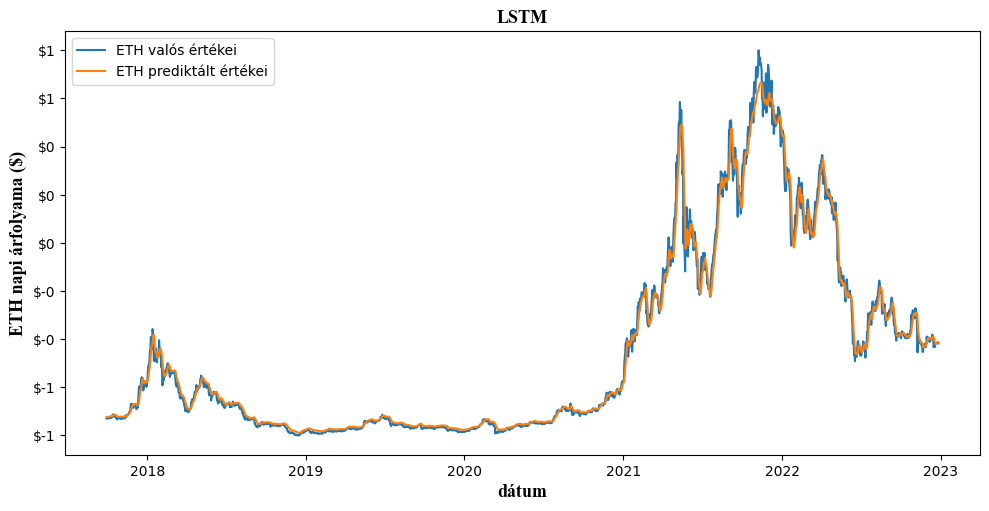

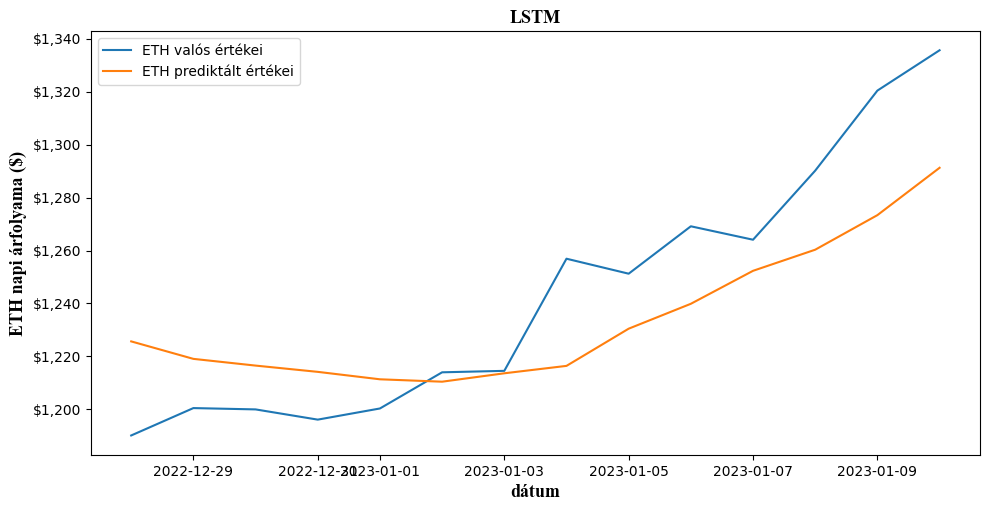

    true_values  predicted_values
0   1190.149942       1225.674340
1   1200.490041       1219.075103
2   1199.989945       1216.536751
3   1196.129972       1214.170026
4   1200.339956       1211.360929
5   1213.999948       1210.454646
6   1214.550025       1213.626566
7   1256.900055       1216.425666
8   1251.240047       1230.473401
9   1269.140012       1239.876243
10  1264.070066       1252.327107
11  1290.160014       1260.303297
12  1320.389973       1273.354924
13  1335.620015       1291.237008
(1930, 28, 1) (14, 28, 1) (1930, 1) (14, 1)
Epoch: 1
Batch 100, Loss: 0.611

Val Loss: 0.031
***************************************************

Epoch: 2
Batch 100, Loss: 0.045

Val Loss: 0.017
***************************************************

Epoch: 3
Batch 100, Loss: 0.019

Val Loss: 0.013
***************************************************

Epoch: 4
Batch 100, Loss: 0.012

Val Loss: 0.005
***************************************************

Epoch: 5
Batch 100, Loss: 0.007

Val L

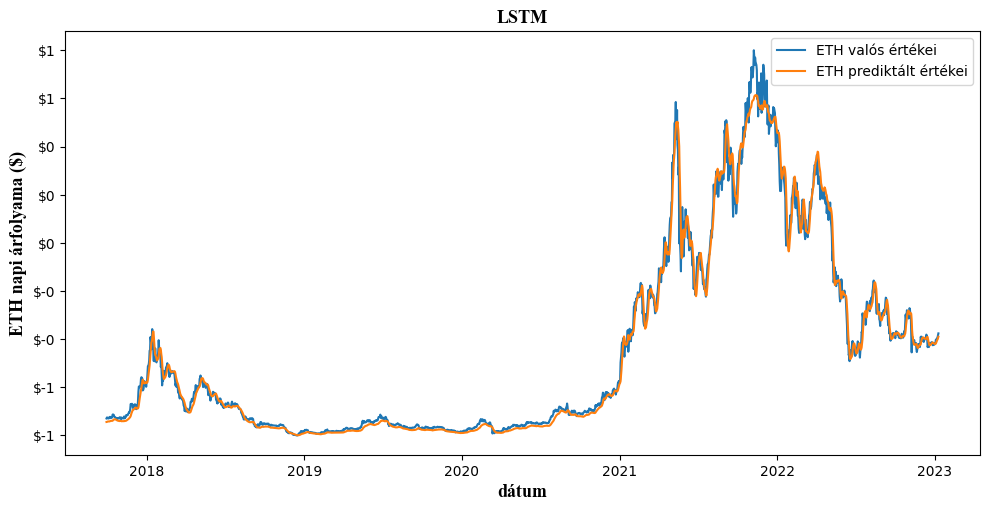

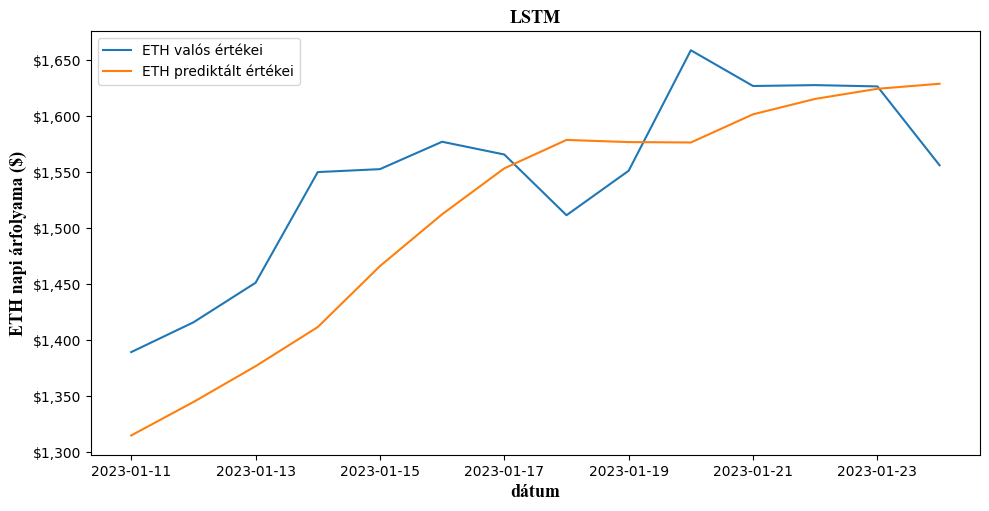

    true_values  predicted_values
0   1389.390024       1315.062587
1   1415.920020       1344.865591
2   1451.200003       1376.810053
3   1549.899999       1411.708488
4   1552.520011       1466.060253
5   1576.940017       1512.281097
6   1565.570018       1553.230381
7   1511.430005       1578.564483
8   1551.089979       1576.652096
9   1658.519969       1576.294764
10  1626.659983       1601.406132
11  1627.439975       1615.164679
12  1626.289980       1624.161616
13  1555.969996       1628.652622
(1944, 28, 1) (14, 28, 1) (1944, 1) (14, 1)
Epoch: 1
Batch 100, Loss: 0.235

Val Loss: 0.012
***************************************************

Epoch: 2
Batch 100, Loss: 0.047

Val Loss: 0.002
***************************************************

Epoch: 3
Batch 100, Loss: 0.010

Val Loss: 0.000
***************************************************

Epoch: 4
Batch 100, Loss: 0.004

Val Loss: 0.000
***************************************************

Epoch: 5
Batch 100, Loss: 0.003

Val L

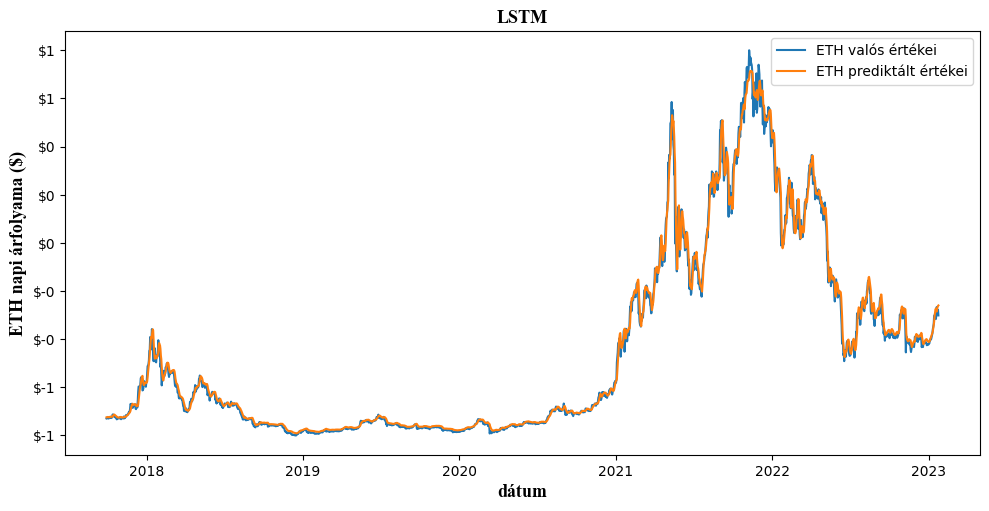

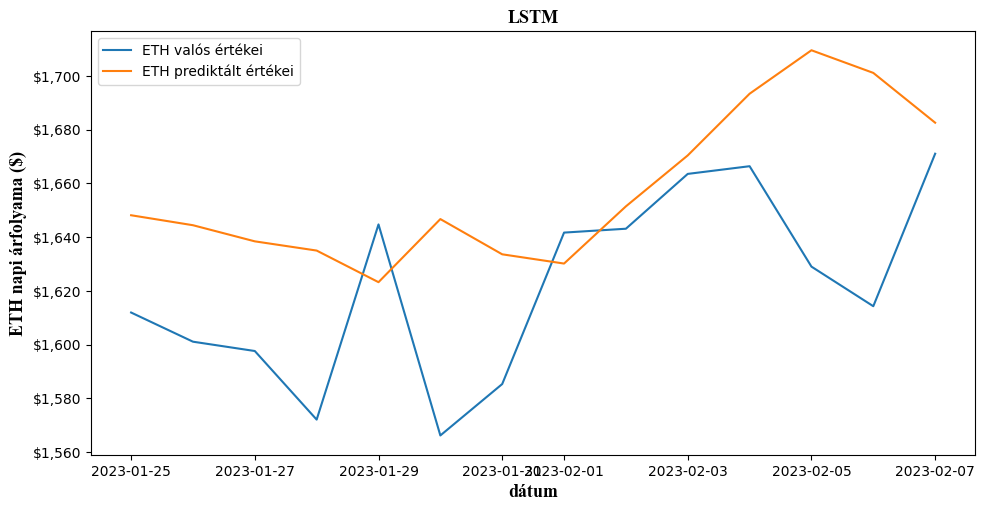

    true_values  predicted_values
0   1611.940033       1648.133056
1   1601.089982       1644.423449
2   1597.620004       1638.425397
3   1572.099985       1634.994419
4   1644.720029       1623.233581
5   1566.199995       1646.711120
6   1585.329996       1633.600220
7   1641.680033       1630.157204
8   1643.119990       1651.441896
9   1663.520012       1670.402453
10  1666.380005       1693.347444
11  1629.020021       1709.520656
12  1614.290004       1701.096957
13  1671.029966       1682.570464
(1958, 28, 1) (14, 28, 1) (1958, 1) (14, 1)
Epoch: 1
Batch 100, Loss: 0.380

Val Loss: 0.005
***************************************************

Epoch: 2
Batch 100, Loss: 0.015

Val Loss: 0.002
***************************************************

Epoch: 3
Batch 100, Loss: 0.009

Val Loss: 0.001
***************************************************

Epoch: 4
Batch 100, Loss: 0.006

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.005

Val L

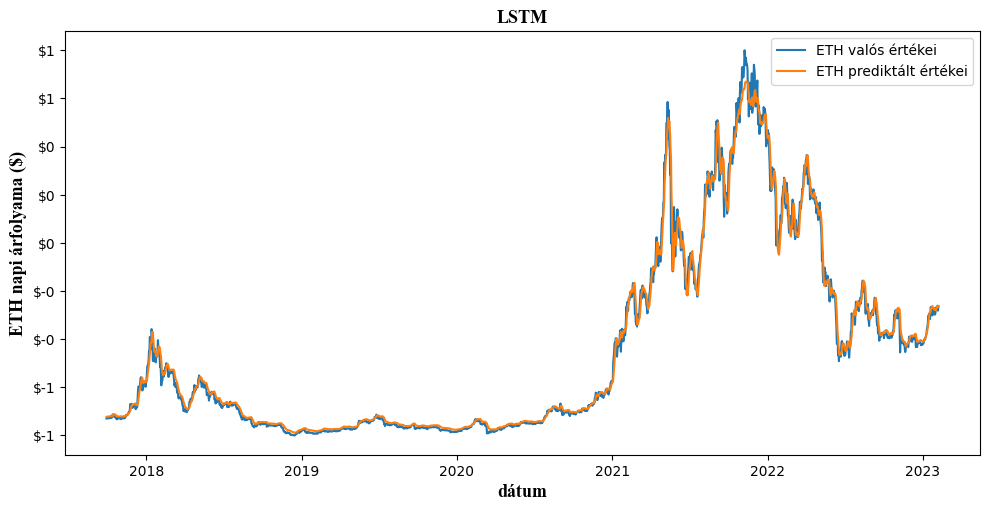

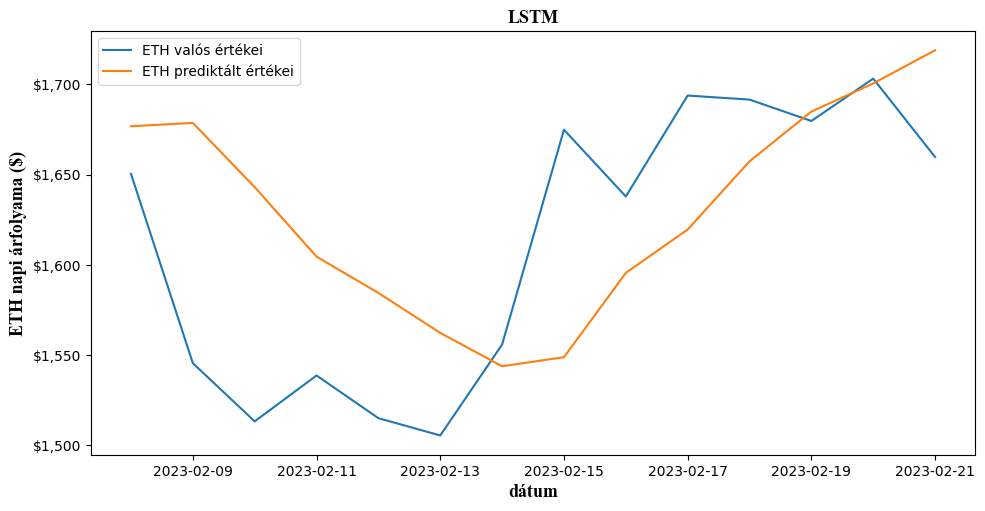

    true_values  predicted_values
0   1650.430019       1676.831471
1   1545.350000       1678.683600
2   1513.060033       1643.051213
3   1538.510008       1604.479637
4   1514.830009       1584.331846
5   1505.239983       1562.160370
6   1555.710022       1543.631414
7   1674.919999       1548.679608
8   1637.839981       1595.444405
9   1693.869996       1619.510810
10  1691.619987       1657.370678
11  1679.750034       1684.978724
12  1703.270022       1700.605450
13  1659.760001       1719.000442
(1972, 28, 1) (14, 28, 1) (1972, 1) (14, 1)
Epoch: 1
Batch 100, Loss: 0.595

Val Loss: 0.022
***************************************************

Epoch: 2
Batch 100, Loss: 0.041

Val Loss: 0.003
***************************************************

Epoch: 3
Batch 100, Loss: 0.008

Val Loss: 0.000
***************************************************

Epoch: 4
Batch 100, Loss: 0.006

Val Loss: 0.000
***************************************************

Epoch: 5
Batch 100, Loss: 0.005

Val L

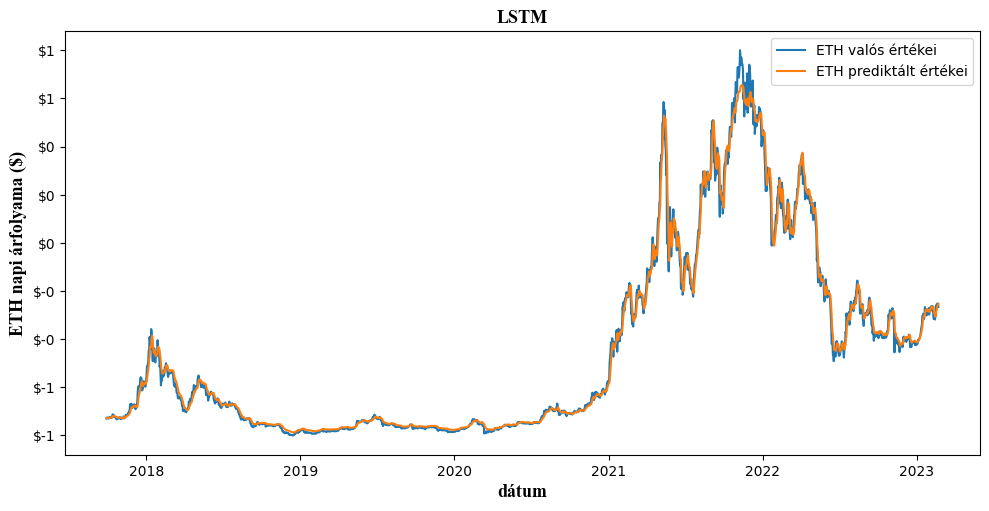

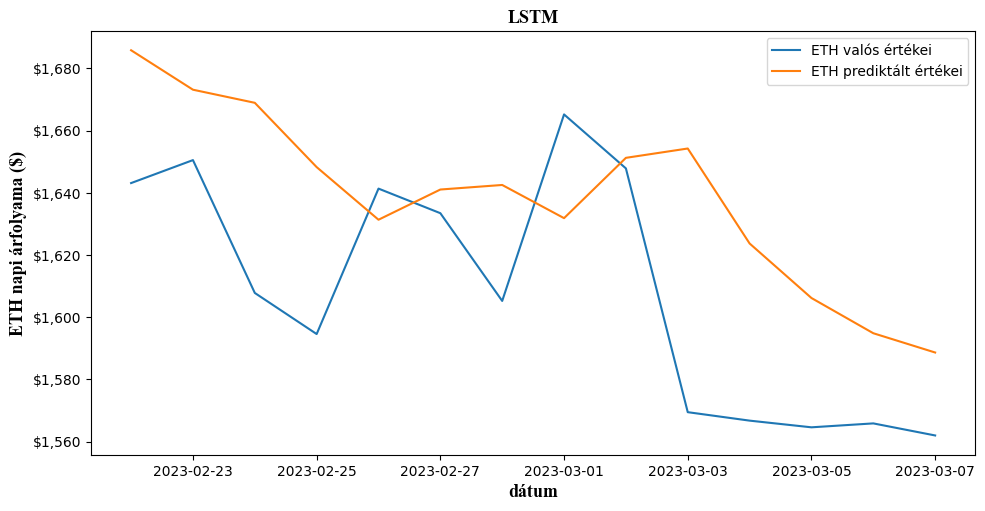

    true_values  predicted_values
0   1643.139983       1685.857904
1   1650.529982       1673.171916
2   1607.800023       1668.955737
3   1594.580008       1648.275397
4   1641.360011       1631.350141
5   1633.449994       1641.064135
6   1605.229992       1642.528098
7   1665.220013       1631.857698
8   1647.859989       1651.256120
9   1569.449984       1654.257540
10  1566.730010       1623.710305
11  1564.580034       1606.170347
12  1565.839988       1594.840334
13  1561.960022       1588.639963
Tesztelve 10 különböző tanulási/tesztelési adatszetten
RMSE: 58.0182
MSE: 3997.8238
MAE: 44.0015
MAPE: 3.1437%


In [11]:
model, evaluation_df, rmse, mse, mae, mape = gridsearch_timeseriessplit(data, ["eth_close"], lookback = 28, test_size=14, batch_size=16, learning_rate=0.002, num_epochs=15, tss_split=10, plot_train=True, plot_test=True)

## Test on Real World Example

## 1 DAY

In [12]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
       
    for i in range(1, n_steps+1):
        df[f'eth_close(t-{i})'] = df['eth_close'].shift(i)
        
    df.dropna(inplace=True)
    
    return df

In [13]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [15]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [16]:
timedelta = 0

In [17]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-08', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)
eth_current_price.index = pd.to_datetime(eth_current_price.index)
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=timedelta)] ## 1 day
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)
eth_current_price = eth_current_price[["eth_close"]]
eth_current_price

,eth_close
Date,
2023-03-08,1534.088257


In [18]:
data = data[["eth_close"]]

In [19]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [20]:
lookback = 2
shifted_df = prepare_dataframe_for_lstm(data, lookback)

In [21]:
shifted_df_as_np = shifted_df.to_numpy()

In [22]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

In [23]:
X = shifted_df_as_np[:, 1:] ## első oszlop tartalmazza a forecastot
y = shifted_df_as_np[:, 0]

In [24]:
X = dc(np.flip(X, axis=1))

In [25]:
X = X.reshape((-1, lookback, 1))
y = y.reshape((-1, 1))

In [26]:
X = torch.tensor(X).float()
y = torch.tensor(y).float()

In [27]:
train_dataset = TimeSeriesDataset(X, y)
#test_dataset = TimeSeriesDataset(X_test, y_test)

In [28]:
X.shape

torch.Size([2012, 2, 1])

In [29]:
y.shape

torch.Size([2012, 1])

In [30]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 2, 1]) torch.Size([16, 1])


In [32]:
model = LSTM(1, 4, 1) #1 feature, 4 hidden size, num stacked layer 
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [33]:
learning_rate = 0.0025
num_epochs = 15
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    #validate_one_epoch(model, epoch, test_loader, device, loss_function, optimizer)

Epoch: 1
Batch 100, Loss: 0.570

Epoch: 2
Batch 100, Loss: 0.107

Epoch: 3
Batch 100, Loss: 0.016

Epoch: 4
Batch 100, Loss: 0.006

Epoch: 5
Batch 100, Loss: 0.005

Epoch: 6
Batch 100, Loss: 0.004

Epoch: 7
Batch 100, Loss: 0.003

Epoch: 8
Batch 100, Loss: 0.003

Epoch: 9
Batch 100, Loss: 0.002

Epoch: 10
Batch 100, Loss: 0.002

Epoch: 11
Batch 100, Loss: 0.002

Epoch: 12
Batch 100, Loss: 0.002

Epoch: 13
Batch 100, Loss: 0.002

Epoch: 14
Batch 100, Loss: 0.002

Epoch: 15
Batch 100, Loss: 0.002



In [34]:
##TRAIN LOSS
with torch.no_grad():
    predicted = model(X.to(device)).to('cpu').numpy()

In [35]:
train_predictions = predicted.flatten()

dummies = np.zeros((X.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 344.7400169 ,  331.67107276,  299.51401381, ..., 1530.07652374,
       1527.48959817, 1527.53296233])

In [36]:
dummies = np.zeros((X.shape[0], lookback+1))
dummies[:, 0] = y.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 341.76999431,  283.77000785,  312.0900426 , ..., 1564.58003429,
       1565.83998841, 1561.96002242])

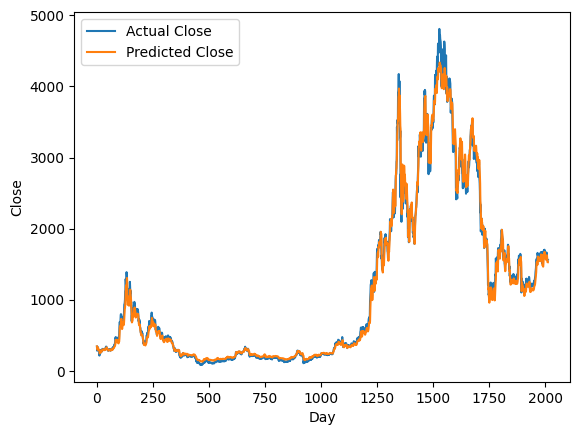

In [37]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [38]:
## Creating X_test

In [39]:
forecast_x = prepare_dataframe_for_lstm(pd.concat([data, eth_current_price]), lookback)[-len(eth_current_price):]

In [40]:
forecast_x = forecast_x.to_numpy()

In [41]:
forecast_x = scaler.transform(forecast_x)

In [42]:
X_test = forecast_x[:, 1:] ## első oszlop tartalmazza a forecastot
y_test = forecast_x[:, 0]

In [43]:
X_test = X_test.reshape((-1, lookback, 1))
y_test = y_test.reshape((-1, 1))

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

print(X_test.shape, y_test.shape)

torch.Size([1, 2, 1]) torch.Size([1, 1])


In [44]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([1526.50292273])

In [45]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([1534.08827172])

In [46]:
evaluation_df = pd.DataFrame()
evaluation_df["true_values"] = new_y_test
evaluation_df["predicted_values"] = test_predictions
print(evaluation_df)

   true_values  predicted_values
0  1534.088272       1526.502923


In [47]:
rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)    
mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])


print(f"RMSE: {round(rmse, 4)}")
print(f"MSE: {round(mse, 4)}")
print(f"MAE: {round(mae, 4)}")
print(f"MAPE: {str(round(mape*100, 4))}%")

RMSE: 7.5853
MSE: 57.5375
MAE: 7.5853
MAPE: 0.4945%


In [48]:
del device

## 3 DAY

In [49]:
timedelta = 2 #minus 1 day from purpose

In [50]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-08', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)
eth_current_price.index = pd.to_datetime(eth_current_price.index)
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=timedelta)] ## 1 day
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)
eth_current_price = eth_current_price[["eth_close"]]
eth_current_price

,eth_close
Date,
2023-03-08,1534.088257
2023-03-09,1438.660767
2023-03-10,1429.158081


In [51]:
data = data[["eth_close"]]

In [52]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [53]:
lookback = 6
shifted_df = prepare_dataframe_for_lstm(data, lookback)

In [54]:
shifted_df_as_np = shifted_df.to_numpy()

In [55]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

In [56]:
X = shifted_df_as_np[:, 1:] ## első oszlop tartalmazza a forecastot
y = shifted_df_as_np[:, 0]

In [57]:
X = dc(np.flip(X, axis=1))

In [58]:
X = X.reshape((-1, lookback, 1))
y = y.reshape((-1, 1))

In [59]:
X = torch.tensor(X).float()
y = torch.tensor(y).float()

In [60]:
train_dataset = TimeSeriesDataset(X, y)
#test_dataset = TimeSeriesDataset(X_test, y_test)

In [61]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [62]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 6, 1]) torch.Size([16, 1])


In [63]:
model = LSTM(1, 4, 1) #1 feature, 4 hidden size, num stacked layer 
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [64]:
learning_rate = 0.0025
num_epochs = 15
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    #validate_one_epoch(model, epoch, test_loader, device, loss_function, optimizer)

Epoch: 1
Batch 100, Loss: 0.174

Epoch: 2
Batch 100, Loss: 0.016

Epoch: 3
Batch 100, Loss: 0.005

Epoch: 4
Batch 100, Loss: 0.004

Epoch: 5
Batch 100, Loss: 0.003

Epoch: 6
Batch 100, Loss: 0.002

Epoch: 7
Batch 100, Loss: 0.002

Epoch: 8
Batch 100, Loss: 0.002

Epoch: 9
Batch 100, Loss: 0.002

Epoch: 10
Batch 100, Loss: 0.002

Epoch: 11
Batch 100, Loss: 0.001

Epoch: 12
Batch 100, Loss: 0.001

Epoch: 13
Batch 100, Loss: 0.001

Epoch: 14
Batch 100, Loss: 0.001

Epoch: 15
Batch 100, Loss: 0.001



In [65]:
##TRAIN LOSS
with torch.no_grad():
    predicted = model(X.to(device)).to('cpu').numpy()

In [66]:
train_predictions = predicted.flatten()

dummies = np.zeros((X.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 334.04103674,  337.83497837,  327.53190737, ..., 1571.02116078,
       1559.83419303, 1555.8990363 ])

In [67]:
dummies = np.zeros((X.shape[0], lookback+1))
dummies[:, 0] = y.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 334.49002475,  302.99004546,  296.7399747 , ..., 1564.58003429,
       1565.83998841, 1561.96002242])

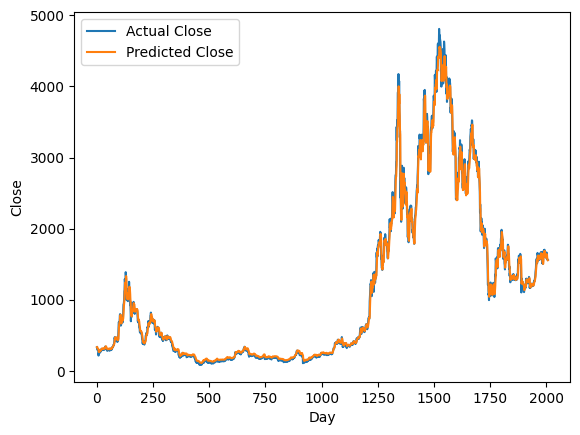

In [68]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [69]:
## Creating X_test

In [70]:
forecast_x = prepare_dataframe_for_lstm(pd.concat([data, eth_current_price]), lookback)[-len(eth_current_price):]

In [71]:
forecast_x = forecast_x.to_numpy()

In [72]:
forecast_x = scaler.transform(forecast_x)

In [73]:
forecast_x

array([[-0.38600308, -0.37420357, -0.37256097, -0.37309439, -0.37218419,
        -0.37103268, -0.33783778],
       [-0.42640234, -0.38600308, -0.37420357, -0.37256097, -0.37309439,
        -0.37218419, -0.37103268],
       [-0.43042531, -0.42640234, -0.38600308, -0.37420357, -0.37256097,
        -0.37309439, -0.37218419]])

In [74]:
X_test = forecast_x[:, 1:] ## első oszlop tartalmazza a forecastot
y_test = forecast_x[:, 0]

In [75]:
X_test = X_test.reshape((-1, lookback, 1))
y_test = y_test.reshape((-1, 1))

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

print(X_test.shape, y_test.shape)

torch.Size([3, 6, 1]) torch.Size([3, 1])


In [76]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([1610.25136478, 1561.71814052, 1561.72665848])

In [77]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([1534.08827172, 1438.66079134, 1429.1580566 ])

In [78]:
evaluation_df = pd.DataFrame()
evaluation_df["true_values"] = new_y_test
evaluation_df["predicted_values"] = test_predictions
print(evaluation_df)

   true_values  predicted_values
0  1534.088272       1610.251365
1  1438.660791       1561.718141
2  1429.158057       1561.726658


In [79]:
rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)    
mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])


print(f"RMSE: {round(rmse, 4)}")
print(f"MSE: {round(mse, 4)}")
print(f"MAE: {round(mae, 4)}")
print(f"MAPE: {str(round(mape*100, 4))}%")

RMSE: 113.3113
MSE: 12839.454
MAE: 110.5963
MAPE: 7.5981%


In [80]:
del device

## 7 DAY

In [81]:
timedelta = 6 #minus 1 day from purpose

In [82]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-08', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)
eth_current_price.index = pd.to_datetime(eth_current_price.index)
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=timedelta)] ## 1 day
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)
eth_current_price = eth_current_price[["eth_close"]]
eth_current_price

,eth_close
Date,
2023-03-08,1534.088257
2023-03-09,1438.660767
2023-03-10,1429.158081
2023-03-11,1482.616699
2023-03-12,1590.292969
2023-03-13,1680.308960
2023-03-14,1703.507080


In [83]:
data = data[["eth_close"]]

In [84]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [85]:
lookback = 14 #8
shifted_df = prepare_dataframe_for_lstm(data, lookback)

In [86]:
shifted_df_as_np = shifted_df.to_numpy()

In [87]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

In [88]:
X = shifted_df_as_np[:, 1:] ## első oszlop tartalmazza a forecastot
y = shifted_df_as_np[:, 0]

In [89]:
X = dc(np.flip(X, axis=1))

In [90]:
X = X.reshape((-1, lookback, 1))
y = y.reshape((-1, 1))

In [91]:
X = torch.tensor(X).float()
y = torch.tensor(y).float()

In [92]:
train_dataset = TimeSeriesDataset(X, y)
#test_dataset = TimeSeriesDataset(X_test, y_test)

In [93]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [94]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 14, 1]) torch.Size([16, 1])


In [95]:
model = LSTM(1, 4, 1) #1 feature, 4 hidden size, num stacked layer 
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [96]:
learning_rate = 0.0025
num_epochs = 15
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    #validate_one_epoch(model, epoch, test_loader, device, loss_function, optimizer)

Epoch: 1
Batch 100, Loss: 0.358

Epoch: 2
Batch 100, Loss: 0.053

Epoch: 3
Batch 100, Loss: 0.014

Epoch: 4
Batch 100, Loss: 0.006

Epoch: 5
Batch 100, Loss: 0.003

Epoch: 6
Batch 100, Loss: 0.003

Epoch: 7
Batch 100, Loss: 0.002

Epoch: 8
Batch 100, Loss: 0.002

Epoch: 9
Batch 100, Loss: 0.002

Epoch: 10
Batch 100, Loss: 0.002

Epoch: 11
Batch 100, Loss: 0.002

Epoch: 12
Batch 100, Loss: 0.002

Epoch: 13
Batch 100, Loss: 0.002

Epoch: 14
Batch 100, Loss: 0.001

Epoch: 15
Batch 100, Loss: 0.002



In [97]:
##TRAIN LOSS
with torch.no_grad():
    predicted = model(X.to(device)).to('cpu').numpy()

In [98]:
train_predictions = predicted.flatten()

dummies = np.zeros((X.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 253.59319861,  251.41485353,  248.55493086, ..., 1605.05935136,
       1592.50415989, 1587.68609197])

In [99]:
dummies = np.zeros((X.shape[0], lookback+1))
dummies[:, 0] = y.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 253.00003885,  249.31000225,  257.55003742, ..., 1564.58003429,
       1565.83998841, 1561.96002242])

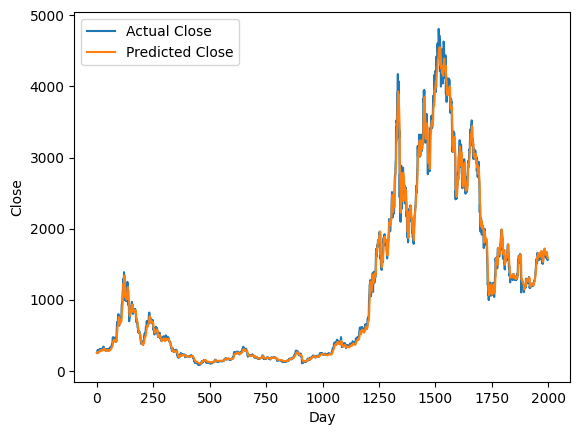

In [100]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [101]:
## Creating X_test

In [102]:
forecast_x = prepare_dataframe_for_lstm(pd.concat([data, eth_current_price]), lookback)[-len(eth_current_price):]

In [103]:
forecast_x = forecast_x.to_numpy()

In [104]:
forecast_x = scaler.transform(forecast_x)

In [105]:
forecast_x

array([[-0.38600308, -0.37420357, -0.37256097, -0.37309439, -0.37218419,
        -0.37103268, -0.33783778, -0.33048842, -0.3558852 , -0.34393826,
        -0.34058956, -0.36039389, -0.35479719, -0.33670744, -0.33983599],
       [-0.42640234, -0.38600308, -0.37420357, -0.37256097, -0.37309439,
        -0.37218419, -0.37103268, -0.33783778, -0.33048842, -0.3558852 ,
        -0.34393826, -0.34058956, -0.36039389, -0.35479719, -0.33670744],
       [-0.43042531, -0.42640234, -0.38600308, -0.37420357, -0.37256097,
        -0.37309439, -0.37218419, -0.37103268, -0.33783778, -0.33048842,
        -0.3558852 , -0.34393826, -0.34058956, -0.36039389, -0.35479719],
       [-0.40779358, -0.43042531, -0.42640234, -0.38600308, -0.37420357,
        -0.37256097, -0.37309439, -0.37218419, -0.37103268, -0.33783778,
        -0.33048842, -0.3558852 , -0.34393826, -0.34058956, -0.36039389],
       [-0.3622088 , -0.40779358, -0.43042531, -0.42640234, -0.38600308,
        -0.37420357, -0.37256097, -0.37309439, 

In [106]:
X_test = forecast_x[:, 1:] ## első oszlop tartalmazza a forecastot
y_test = forecast_x[:, 0]

In [107]:
X_test = X_test.reshape((-1, lookback, 1))
y_test = y_test.reshape((-1, 1))

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

print(X_test.shape, y_test.shape)

torch.Size([7, 14, 1]) torch.Size([7, 1])


In [108]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([1660.98461619, 1653.34998975, 1632.30696791, 1637.32552468,
       1659.71705927, 1653.43685887, 1649.00231033])

In [109]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([1534.08827172, 1438.66079134, 1429.1580566 , 1482.61670324,
       1590.29293971, 1680.30898121, 1703.50704693])

In [110]:
evaluation_df = pd.DataFrame()
evaluation_df["true_values"] = new_y_test
evaluation_df["predicted_values"] = test_predictions
print(evaluation_df)

   true_values  predicted_values
0  1534.088272       1660.984616
1  1438.660791       1653.349990
2  1429.158057       1632.306968
3  1482.616703       1637.325525
4  1590.292940       1659.717059
5  1680.308981       1653.436859
6  1703.507047       1649.002310


In [111]:
rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)    
mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])


print(f"RMSE: {round(rmse, 4)}")
print(f"MSE: {round(mse, 4)}")
print(f"MAE: {round(mae, 4)}")
print(f"MAPE: {str(round(mape*100, 4))}%")

RMSE: 139.3408
MSE: 19415.8599
MAE: 121.4635
MAPE: 8.1441%


In [112]:
del device

In [113]:
date_indexek = eth_current_price.index

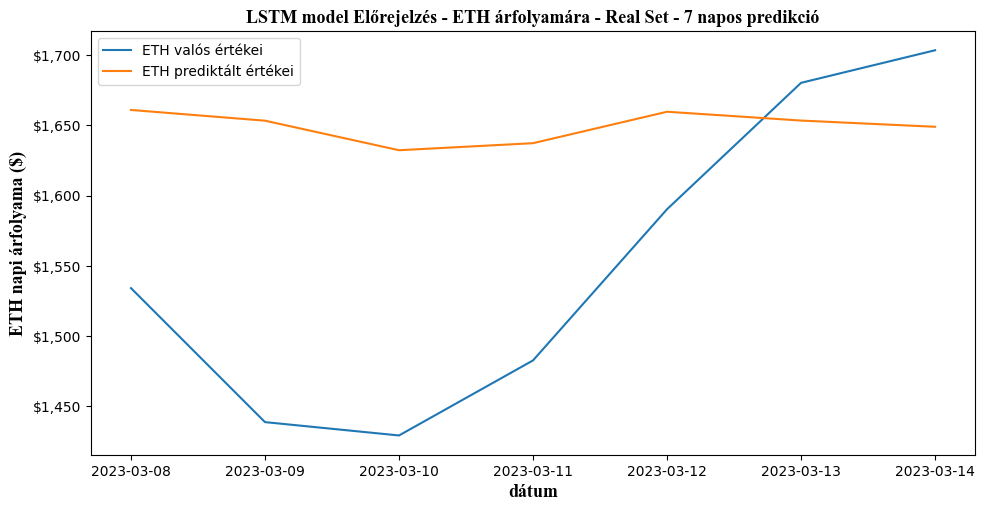

In [114]:
fig, ax = plt.subplots(figsize=(10, 5))
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
ax.plot(date_indexek, evaluation_df["true_values"], label="ETH valós értékei")
ax.plot(date_indexek, evaluation_df["predicted_values"], label="ETH prediktált értékei")
ax.legend()
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel("ETH napi árfolyama ($)", **font)
ax.set_xlabel("dátum", **font)
plt.tight_layout()
ax.set_title("LSTM model Előrejelzés - ETH árfolyamára - Real Set - 7 napos predikció", **font)
plt.savefig("charts/forecast/xgb_realword_7.png")
plt.show()

## 14 DAY

In [115]:
timedelta = 13 #minus 1 day from purpose

In [116]:
import yfinance as yf

# Define the ticker symbol
tickerSymbol = 'ETH-USD'

# Get data for this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2023-03-08', end='2023-03-24')

eth_current_price = pd.DataFrame(tickerDf)
eth_current_price.index = pd.to_datetime(eth_current_price.index)
eth_current_price = eth_current_price[pd.to_datetime("2023-03-08"):pd.to_datetime("2023-03-08") + pd.Timedelta(days=timedelta)] ## 1 day
eth_current_price.rename(columns={"Close": "eth_close"}, inplace=True)
eth_current_price = eth_current_price[["eth_close"]]
eth_current_price

,eth_close
Date,
2023-03-08,1534.088257
2023-03-09,1438.660767
2023-03-10,1429.158081
2023-03-11,1482.616699
2023-03-12,1590.292969
2023-03-13,1680.308960
2023-03-14,1703.507080
2023-03-15,1656.180542
2023-03-16,1677.215454


In [117]:
data = data[["eth_close"]]

In [118]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [119]:
lookback = 28 #28
shifted_df = prepare_dataframe_for_lstm(data, lookback)

In [120]:
shifted_df_as_np = shifted_df.to_numpy()

In [121]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

In [122]:
X = shifted_df_as_np[:, 1:] ## első oszlop tartalmazza a forecastot
y = shifted_df_as_np[:, 0]

In [123]:
X = dc(np.flip(X, axis=1))

In [124]:
X = X.reshape((-1, lookback, 1))
y = y.reshape((-1, 1))

In [125]:
X = torch.tensor(X).float()
y = torch.tensor(y).float()

In [126]:
train_dataset = TimeSeriesDataset(X, y)
#test_dataset = TimeSeriesDataset(X_test, y_test)

In [127]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [128]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 28, 1]) torch.Size([16, 1])


In [129]:
model = LSTM(1, 4, 1) #1 feature, 4 hidden size, num stacked layer 
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [130]:
learning_rate = 0.0025
num_epochs = 15
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    #validate_one_epoch(model, epoch, test_loader, device, loss_function, optimizer)

Epoch: 1
Batch 100, Loss: 0.179

Epoch: 2
Batch 100, Loss: 0.012

Epoch: 3
Batch 100, Loss: 0.008

Epoch: 4
Batch 100, Loss: 0.005

Epoch: 5
Batch 100, Loss: 0.004

Epoch: 6
Batch 100, Loss: 0.003

Epoch: 7
Batch 100, Loss: 0.003

Epoch: 8
Batch 100, Loss: 0.002

Epoch: 9
Batch 100, Loss: 0.002

Epoch: 10
Batch 100, Loss: 0.002

Epoch: 11
Batch 100, Loss: 0.002

Epoch: 12
Batch 100, Loss: 0.002

Epoch: 13
Batch 100, Loss: 0.002

Epoch: 14
Batch 100, Loss: 0.002

Epoch: 15
Batch 100, Loss: 0.002



In [131]:
##TRAIN LOSS
with torch.no_grad():
    predicted = model(X.to(device)).to('cpu').numpy()

In [132]:
train_predictions = predicted.flatten()

dummies = np.zeros((X.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 284.0614488 ,  283.87644715,  286.44873028, ..., 1601.05774046,
       1582.17539422, 1572.49343033])

In [133]:
dummies = np.zeros((X.shape[0], lookback+1))
dummies[:, 0] = y.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 292.21996498,  304.3599587 ,  303.94997027, ..., 1564.58003429,
       1565.83998841, 1561.96002242])

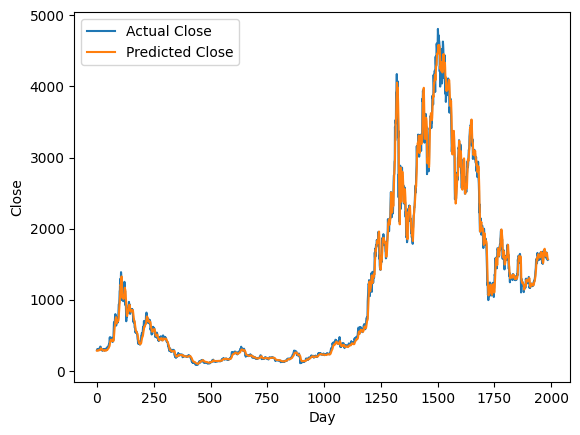

In [134]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [135]:
## Creating X_test

In [136]:
forecast_x = prepare_dataframe_for_lstm(pd.concat([data, eth_current_price]), lookback)[-len(eth_current_price):]

In [137]:
forecast_x = forecast_x.to_numpy()

In [138]:
forecast_x = scaler.transform(forecast_x)

In [139]:
forecast_x

array([[-0.38600308, -0.37420357, -0.37256097, -0.37309439, -0.37218419,
        -0.37103268, -0.33783778, -0.33048842, -0.3558852 , -0.34393826,
        -0.34058956, -0.36039389, -0.35479719, -0.33670744, -0.33983599,
        -0.33279991, -0.31437994, -0.32433714, -0.31931197, -0.31835943,
        -0.34207975, -0.32638192, -0.37684951, -0.398216  , -0.39415607,
        -0.38413114, -0.3949054 , -0.38123542, -0.33674977],
       [-0.42640234, -0.38600308, -0.37420357, -0.37256097, -0.37309439,
        -0.37218419, -0.37103268, -0.33783778, -0.33048842, -0.3558852 ,
        -0.34393826, -0.34058956, -0.36039389, -0.35479719, -0.33670744,
        -0.33983599, -0.33279991, -0.31437994, -0.32433714, -0.31931197,
        -0.31835943, -0.34207975, -0.32638192, -0.37684951, -0.398216  ,
        -0.39415607, -0.38413114, -0.3949054 , -0.38123542],
       [-0.43042531, -0.42640234, -0.38600308, -0.37420357, -0.37256097,
        -0.37309439, -0.37218419, -0.37103268, -0.33783778, -0.33048842,
  

In [140]:
X_test = forecast_x[:, 1:] ## első oszlop tartalmazza a forecastot
y_test = forecast_x[:, 0]

In [141]:
X_test = X_test.reshape((-1, lookback, 1))
y_test = y_test.reshape((-1, 1))

X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

print(X_test.shape, y_test.shape)

torch.Size([14, 28, 1]) torch.Size([14, 1])


In [142]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([1586.18664942, 1529.33905143, 1517.13499702, 1524.21461853,
       1531.24679289, 1567.0036403 , 1627.76626166, 1679.65964515,
       1684.08356384, 1707.85564151, 1703.90147776, 1695.9419017 ,
       1685.92759658, 1657.43945531])

In [143]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([1534.08827172, 1438.66079134, 1429.1580566 , 1482.61670324,
       1590.29293971, 1680.30898121, 1703.50704693, 1656.18055714,
       1677.2154834 , 1792.48509405, 1761.65965271, 1785.5765357 ,
       1735.3212756 , 1806.76077265])

In [144]:
evaluation_df = pd.DataFrame()
evaluation_df["true_values"] = new_y_test
evaluation_df["predicted_values"] = test_predictions
print(evaluation_df)

    true_values  predicted_values
0   1534.088272       1586.186649
1   1438.660791       1529.339051
2   1429.158057       1517.134997
3   1482.616703       1524.214619
4   1590.292940       1531.246793
5   1680.308981       1567.003640
6   1703.507047       1627.766262
7   1656.180557       1679.659645
8   1677.215483       1684.083564
9   1792.485094       1707.855642
10  1761.659653       1703.901478
11  1785.576536       1695.941902
12  1735.321276       1685.927597
13  1806.760773       1657.439455


In [145]:
rmse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=False)
mse = mean_squared_error(evaluation_df['true_values'], evaluation_df["predicted_values"], squared=True)    
mae = mean_absolute_error(evaluation_df['true_values'], evaluation_df["predicted_values"])
mape = mean_absolute_percentage_error(evaluation_df['true_values'], evaluation_df["predicted_values"])


print(f"RMSE: {round(rmse, 4)}")
print(f"MSE: {round(mse, 4)}")
print(f"MAE: {round(mae, 4)}")
print(f"MAPE: {str(round(mape*100, 4))}%")

RMSE: 78.5293
MSE: 6166.8485
MAE: 70.1092
MAPE: 4.2515%


In [146]:
date_indexek = eth_current_price.index

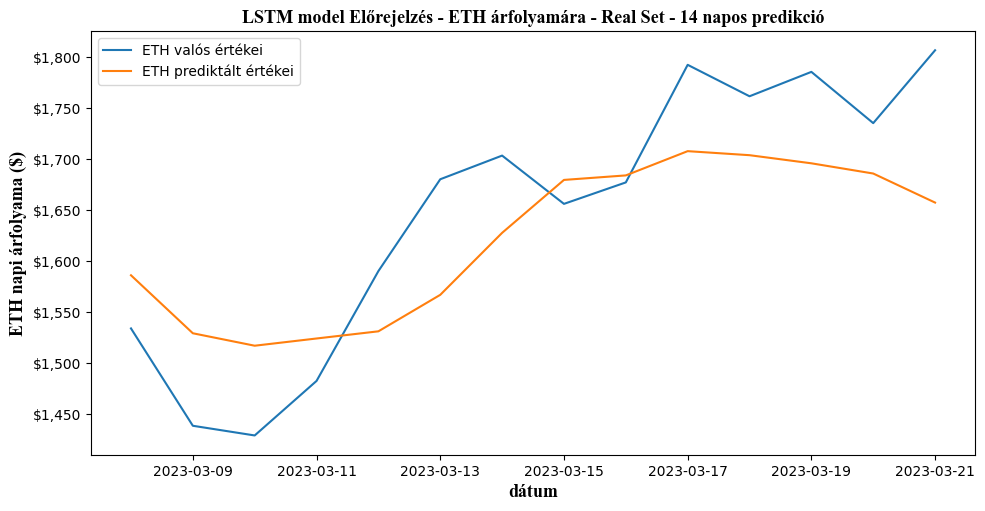

In [147]:
fig, ax = plt.subplots(figsize=(10, 5))
font = {'fontname':'Times New Roman', 'size': 13, 'weight' : 'bold'}
ax.plot(date_indexek, evaluation_df["true_values"], label="ETH valós értékei")
ax.plot(date_indexek, evaluation_df["predicted_values"], label="ETH prediktált értékei")
ax.legend()
ax.yaxis.set_major_formatter("${x:,.0f}")
ax.set_ylabel("ETH napi árfolyama ($)", **font)
ax.set_xlabel("dátum", **font)
plt.tight_layout()
ax.set_title("LSTM model Előrejelzés - ETH árfolyamára - Real Set - 14 napos predikció", **font)
plt.savefig("charts/forecast/xgb_realword_14.png")
plt.show()